In [ ]:
import hashlib
import numpy as np

def gen_v(row):
    row['Uniprot ID'] = str(hashlib.md5(str.encode(row['Sequence'])).hexdigest())
    return row

def gen_uniprot_id(df):
  df['Uniprot ID'] = None
  out = df.apply(gen_v,axis=1)
  return out

def gen_v_mol(row):
    row['molecule ID'] = str(hashlib.md5(str.encode(row['STANDARDIZED_XTB_SMILES'])).hexdigest())
    return row

def gen_mol_id(df):
  df['molecule ID'] = None
  out = df.apply(gen_v_mol,axis=1)
  return out

In [ ]:
!wget https://zenodo.org/records/11206519/files/ankh_embeddings.hdf5?download=1 -O ankh_embeddings.hdf5

Receiving file (1.3 GB) into: v12_maps.hdf5
Receiving (->relay:tcp:magic-wormhole-transit.debian.net:4001)..
100% 1.25G/1.25G [04:01<00:00, 5.19MB/s]
Received file written to v12_maps.hdf5


In [ ]:
import h5py
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

f = h5py.File('ankh_embeddings.hdf5', 'r')
ankh_map = {}
for key in tqdm(f.keys()):
    ankh_map[key] = np.array(f[key])

  0%|          | 0/1042 [00:00<?, ?it/s]

In [ ]:
import random
from torch.utils.data import DataLoader,Dataset
import h5py
import torch
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm

def custom_collate(original_batch):
    batch_size = len(original_batch)

    max_ankh_len = 0
    for item in original_batch:
        if item[0].shape[0] > max_ankh_len:
            max_ankh_len = item[0].shape[0]


    ankh = torch.zeros((batch_size, max_ankh_len, 768))
    ecfp = torch.zeros((batch_size, 768))
    label = torch.zeros((batch_size))

    idx = 0
    for item in original_batch:
        ankh_el = item[0]
        ankh_pocket_el = item[1]
        ecfp_el = item[2]
        label_el = float(item[3])
        #
        ankh_el = F.pad(ankh_el,(0,0,0,max_ankh_len - ankh_el.shape[0]))
        ankh[idx] = ankh_el
        #
        ecfp[idx] = ecfp_el
        #
        label[idx] = label_el
        #
        idx += 1

    return ankh, ecfp, [label]

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        uniprot_id = row['Uniprot ID']

        ankh = ankh_map[uniprot_id]
        ankh = torch.tensor(ankh)

        emb = torch.tensor(row['molformer'])

        emb = F.normalize(emb,dim=0)
        ankh = F.normalize(ankh,dim=0)

        return ankh, None, emb, row['Binding']


## Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import csv

class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, ffn_size):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, ffn_size)
        #        self.gelu = GELU()
        self.gelu = nn.Mish(inplace=True)
        self.layer2 = nn.Linear(ffn_size, hidden_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.gelu(x)
        x = self.layer2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, attention_dropout_rate, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads

        self.att_size = att_size = hidden_size // num_heads
        self.scale = att_size ** -0.5

        self.linear_q = nn.Linear(hidden_size, num_heads * att_size)
        self.linear_k = nn.Linear(hidden_size, num_heads * att_size)
        self.linear_v = nn.Linear(hidden_size, num_heads * att_size)
        self.att_dropout = nn.Dropout(attention_dropout_rate)

        self.output_layer = nn.Linear(num_heads * att_size, hidden_size)

    def forward(self, q, k, v, attn_bias=None):
        orig_q_size = q.size()

        d_k = self.att_size
        d_v = self.att_size
        batch_size = q.size(0)

        q = self.linear_q(q).view(batch_size, -1, self.num_heads, d_k)
        k = self.linear_k(k).view(batch_size, -1, self.num_heads, d_k)
        v = self.linear_v(v).view(batch_size, -1, self.num_heads, d_v)

        q = q.transpose(1, 2)  # [b, h, q_len, d_k]
        v = v.transpose(1, 2)  # [b, h, v_len, d_v]
        k = k.transpose(1, 2).transpose(2, 3)  # [b, h, d_k, k_len]

        # Scaled Dot-Product Attention.
        # Attention(Q, K, V) = softmax((QK^T)/sqrt(d_k))V
        q = q * self.scale
        x = torch.matmul(q, k)  # [b, h, q_len, k_len]
        if attn_bias is not None:
            x = x + attn_bias
        x = torch.softmax(x, dim=3)

        x = self.att_dropout(x)
        x = x.matmul(v)  # [b, h, q_len, attn]

        x = x.transpose(1, 2).contiguous()  # [b, q_len, h, attn]
        x = x.view(batch_size, -1, self.num_heads * d_v)

        x = self.output_layer(x)

        assert x.size() == orig_q_size
        return x


class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, ffn_size, dropout_rate, attention_dropout_rate, num_heads):
        super(EncoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size)
        self.self_attention = MultiHeadAttention(
            hidden_size, attention_dropout_rate, num_heads)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size)
        self.ffn = FeedForwardNetwork(hidden_size, ffn_size)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, kv, attn_bias=None):
        y = self.self_attention_norm(x)
        kv = self.self_attention_norm(kv)
        y = self.self_attention(y, kv, kv, attn_bias)
        y = self.self_attention_dropout(y)
        x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x

In [ ]:
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
import torch
import transformers.models.convbert as c_bert
from functools import partial

class resBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_conv1=False, strides=1, dropout=0.3):
        super().__init__()

        self.process = nn.Sequential (
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.Mish(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels)
        )

        if use_conv1:
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv1 = None

    def forward(self, x):
        left = self.process(x)
        right = x if self.conv1 is None else self.conv1(x)

        return F.mish(left + right)


class cnnModule(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel=128, dropout=0.2):
        super().__init__()

        self.head = nn.Sequential (
            nn.Conv1d(in_channel, hidden_channel, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(hidden_channel),
            nn.Mish(inplace=True),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(2)
        )

        self.cnn = nn.Sequential (
            resBlock(hidden_channel, out_channel, use_conv1=True, strides=1, dropout=dropout),
            resBlock(out_channel, out_channel, strides=1, dropout=dropout),
            resBlock(out_channel, out_channel, strides=1, dropout=dropout),
        )

        self.bypass_1 = nn.Sequential (
             nn.Conv1d(in_channel, hidden_channel, 7, stride=1, padding=3,dilation=6),
             nn.BatchNorm1d(hidden_channel),
             nn.Mish(inplace=True),
             nn.MaxPool1d(2),
             nn.Conv1d(hidden_channel, out_channel, kernel_size=3, padding=1),
             nn.BatchNorm1d(out_channel),
        )

    def forward(self, x):
        b1 = self.bypass_1(x)
        x = self.head(x)
        x = self.cnn(x)
        x = torch.cat((b1,x),2)
        return x


class GlobalMaxPooling1D(nn.Module):
    def __init__(self):
        """
            Applies global max pooling over timesteps dimension
        """

        super().__init__()
        self.global_max_pool1d = partial(torch.max, dim=1)

    def forward(self, x):
        out, _ = self.global_max_pool1d(x)
        return out

class PredictionHead(nn.Module):
    def __init__(self, dropout=0.2,cls=False):
        super().__init__()
        self.fc = nn.Sequential (
            nn.Linear(5012, 1024),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Dropout(p=dropout),

            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.Mish(),
            nn.Dropout(p=dropout),

            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.fc(x)
        return x

class DeepLPI(nn.Module):
    def __init__(self, molshape, seqshape, dropout=0.3):
        super().__init__()

        self.molshape = molshape
        self.seqshape = seqshape

        self.molcnn = cnnModule(1,64,dropout=dropout)
        self.seqcnn = cnnModule(768,64,dropout=dropout)

        self.lstm = nn.LSTM(32, 32, num_layers=2, batch_first=True, bidirectional=True)
        self.pocket_pool = GlobalMaxPooling1D()

        self.smi_attention_poc = EncoderLayer(64, 64, 0.1, 0.1, 2)

        inb = 71936

        self.mlp = nn.Sequential (
            nn.Linear(inb, 5012),
            nn.BatchNorm1d(5012),
            nn.Mish(),
        )

        self.ki_head = PredictionHead()
        self.kd_head = PredictionHead()
        self.ic50_head = PredictionHead()
        self.enzymatic_head = PredictionHead()

    def forward(self, ankh, ecfp):
        BATCH_SIZE = ankh.shape[0]

        molv = ecfp.reshape(-1,1,768)
        ankh = ankh.transpose(2,1)

        mol = self.molcnn(molv)

        ankh = self.seqcnn(ankh)

        mol = mol.reshape((BATCH_SIZE, -1, 64))
        ankh = ankh.reshape((BATCH_SIZE, -1, 64))

        mol_attention = mol
        mol = self.smi_attention_poc(mol, ankh)
        ankh = self.smi_attention_poc(ankh, mol_attention)

        ankh = self.pocket_pool(ankh)

        mol = mol.flatten(1)
        ankh = ankh.flatten(1)

        x = torch.cat((mol, ankh),1)
        x = x.reshape((BATCH_SIZE,-1,32))
        x, _ = self.lstm(x)
        x = x.flatten(1)

        x = self.mlp(x)

        enzyme_activity = self.enzymatic_head(x).flatten()
        return enzyme_activity

In [ ]:
import torch
import torch.nn as nn
from torch.nn.modules.batchnorm import _BatchNorm


def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
import io
import math
import numpy as np
import torchvision
import statistics

def isNaN(num):
    return num != num

def mse_loss(input, target, ignored_index):
    mask = target == ignored_index
    out = (input[~mask]-target[~mask])**2
    x = out.mean()
    if isNaN(x):
      x = torch.tensor(0.0,requires_grad=True,dtype=torch.float32)
    return x

epoch_count = 0
def train_loop(models, train_dataloader, optimizer, scheduler,log=True):
    global epoch_count
    loop_loss = 0
    step = 0
    count = 0
    preds = []
    truth = []

    if len(models) <= 3:
      for model in models:
        model, _ = model
        model.cuda()
        model.train()

    for idx, data in enumerate(train_dataloader):
        ankh, ecfp, labels = data

        model_preds = []
        for v in models:
          model, optimizer = v
          if len(models) > 3:
            model.cuda()
            model.train()

          label = labels[0]
          weights = []
          for v in label:
            if v == 1:
              weights.append(1)
            else:
              weights.append(0.3)

          loss_fn = nn.BCELoss(weight=torch.tensor(weights,device='cuda'))

          enable_running_stats(model)
          pred = model(ankh.cuda(), ecfp.cuda())
          pred = F.sigmoid(pred)
          loss = loss_fn(pred.cuda(), label.cuda())

          loss.backward()
          optimizer.first_step(zero_grad=True)

          disable_running_stats(model)
          pred = model(ankh.cuda(), ecfp.cuda())
          pred = F.sigmoid(pred)
          loss = loss_fn(pred.cuda(), label.cuda())

          loss.backward()
          optimizer.second_step(zero_grad=True)

          model_preds.append(pred.cpu().detach().numpy())
          if len(models) > 3:
            model.cpu()

          model_preds = np.stack(model_preds)
          pred = model_preds.mean(axis=0)
          preds.extend(pred)
          truth.extend(list(label.cpu().detach().numpy()))

        if step%50 == 0:
            tloss = float(loss.to("cpu"))
            r_preds = []
            for pred in preds:
              r_preds.append(pred.item())
            preds = np.array(r_preds)
            truth = np.array(truth)
            mcc = matthews_corrcoef(truth==1, preds>=0.5)
            preds = []
            truth = []
            print("STEP: " + str(step) + "/" + str(math.ceil(len(train_dataloader))) + " loss: " + str(tloss) + " mcc: " + str(mcc))
            if log == True:
              wandb.log({"loss": loss,  "train_mcc": mcc })
        step += 1
        count -= 1
    epoch_count += 1
    with torch.no_grad():
        return loop_loss/len(train_dataloader)

In [ ]:
from sklearn import metrics
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from sklearn.metrics import matthews_corrcoef
import time
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc
from scipy.stats import entropy as scipy_entropy
from scipy.stats import pearsonr

def calculate_mcc(truth, preds, stds):
    # Calculate global MCC
    global_mcc = matthews_corrcoef(truth==1, preds>=0.5)

    # Define confidence thresholds
    low_thresh = 0.08
    high_thresh = 0.04

    # Calculate MCC for low confidence predictions
    low_conf_mask = stds >= low_thresh
    low_conf_mcc = matthews_corrcoef(truth[low_conf_mask]==1, preds[low_conf_mask]>=0.5)

    # Calculate MCC for medium confidence predictions
    med_conf_mask = (stds < low_thresh) & (stds >= high_thresh)
    med_conf_mcc = matthews_corrcoef(truth[med_conf_mask]==1, preds[med_conf_mask]>=0.5)

    # Calculate MCC for high confidence predictions
    high_conf_mask = stds < high_thresh
    high_conf_mcc = matthews_corrcoef(truth[high_conf_mask]==1, preds[high_conf_mask]>=0.5)

    return global_mcc, low_conf_mcc, med_conf_mcc, high_conf_mcc

def generate_mcnemar_array(truth, preds):
    return [round(pred) == truth_val for pred, truth_val in zip(preds, truth)]

def calc_auprc(preds,truth):
  # Data to plot precision - recall curve
  precision, recall, thresholds = precision_recall_curve(truth, preds)
  # Use AUC function to calculate the area under the curve of precision recall curve
  auc_precision_recall = auc(recall, precision)
  return auc_precision_recall

def test_loop(models, test_loader, epoch,df_test,subset=True):
    preds = []
    truth = []
    entropy_values = []
    std_devs = []

    if len(models) <= 3:
      for model in models:
        model, _ = model
        model.eval()
        model.use_classifier = True
        model.cuda()


    with torch.no_grad():
        for idx, data in tqdm(enumerate(test_loader),total=len(test_loader)):
          ankh, ecfp, labels = data
          model_preds = []
          for model in models:
            if len(models) > 3:
              model.eval()
              model.use_classifier = True
              model.cuda()

            model, _ = model
            pred = model(ankh.cuda(), ecfp.cuda())
            pred = F.sigmoid(pred)
            model_preds.append(pred.cpu().detach().numpy())
            if len(models) > 3:
              model.cpu()

            model_preds = np.stack(model_preds)
            entropy = scipy_entropy(model_preds,axis=0)
            std_dev = model_preds.std(axis=0)
            pred = model_preds.mean(axis=0)
            preds.extend(pred)
            truth.extend(list(labels[0].cpu().detach().numpy()))
            entropy_values.extend(entropy)
            std_devs.extend(std_dev)

    r_preds = []
    for pred in preds:
      r_preds.append(pred.item())
    preds = np.array(r_preds)
    truth = np.array(truth)
    entropy_values = np.array(entropy_values)
    std_devs = np.array(std_devs)
    global_mcc, low_mcc, med_mcc, high_mcc = calculate_mcc(truth,preds,std_devs)
    plot_performance_vs_variance(preds,truth,std_devs)
    return global_mcc, low_mcc, med_mcc, high_mcc, preds, truth, std_devs

## Setup

In [ ]:
import torch


class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [ ]:
import os

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

# KFold Cross Validation

In [ ]:
import pandas as pd

names = []

file_names = [
    "SG_SET_V5_XTB_STANDARDIZED_phosphatase_achiral_binary.pkl",
    "SG_SET_V5_XTB_STANDARDIZED_esterase_binary.pkl",
    "SG_SET_V5_XTB_STANDARDIZED_gt_acceptors_achiral_binary.pkl",
    "SG_SET_V5_XTB_STANDARDIZED_gt_donors_achiral_binary.pkl",
    "SG_SET_V5_XTB_STANDARDIZED_duf_v3_FIXED_D1.pkl",
    "SG_SET_V5_XTB_STANDARDIZED_olea_binary.pkl",
    ["SG_SET_V5_XTB_STANDARDIZED_halogenase_NaBr_binary.pkl","SG_SET_V5_XTB_STANDARDIZED_halogenase_NaCl_binary.pkl",],
    "SG_SET_V5_XTB_STANDARDIZED_aminotransferase_binary.pkl",
    "SG_SET_nitrilase_binary.pkl",
    "SG_SET_V5_XTB_STANDARDIZED_oxidoreductase_0.pkl",
]

sets = []
for i, file_name in enumerate(file_names):
    print(file_name)
    if isinstance(file_name,list):
      dfs = []
      for f in file_name:
        dfs.append(pd.read_pickle(f"/content/drive/MyDrive/{f}"))
      df = pd.concat(dfs)
      names.append(file_name[0])
    else:
      df = pd.read_pickle(f"/content/drive/MyDrive/{file_name}")
      if file_name == 'SG_SET_nitrilase_binary.pkl':
        df['STANDARDIZED_XTB_SMILES'] = df['SMILES']
      # Causes indexing error if we don't drop these
      if file_name == "SG_SET_V5_XTB_STANDARDIZED_oxidoreductase_0.pkl":
        df = df.drop(columns=['molecule ID','Uniprot ID','Substrate','XTB_SMILES'])
      names.append(file_name)
    # print(df)
    df['set'] = names[i]
    sets.append(df)

SG_SET_V5_XTB_STANDARDIZED_phosphatase_achiral_binary.pkl
SG_SET_V5_XTB_STANDARDIZED_esterase_binary.pkl
SG_SET_V5_XTB_STANDARDIZED_gt_acceptors_achiral_binary.pkl
SG_SET_V5_XTB_STANDARDIZED_gt_donors_achiral_binary.pkl
SG_SET_V5_XTB_STANDARDIZED_duf_v3_FIXED_D1.pkl
SG_SET_V5_XTB_STANDARDIZED_olea_binary.pkl
['SG_SET_V5_XTB_STANDARDIZED_halogenase_NaBr_binary.pkl', 'SG_SET_V5_XTB_STANDARDIZED_halogenase_NaCl_binary.pkl']
SG_SET_V5_XTB_STANDARDIZED_aminotransferase_binary.pkl
SG_SET_nitrilase_binary.pkl
SG_SET_V5_XTB_STANDARDIZED_oxidoreductase_0.pkl


In [ ]:
import h5py

f_molformer = h5py.File('../data/embeddings/molformer_embeddings.h5', 'r')

def map_embds(df,train):
  def apply_to_df(row):
    mol_id = row['molecule ID']
    row['molformer'] = np.array(f_molformer[mol_id])
    return row
  df = df.apply(apply_to_df,axis=1)
  return df

Random seed set as 77
----------------------------------------
FOLD:  7
----------------------------------------
--------------------
epoch: 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.49580106139183044 mcc: -0.5393598899705937


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.23508355021476746 mcc: 0.07283650130507749


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.25154322385787964 mcc: 0.18609083945953336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.37280675768852234 mcc: 0.18561785618298318


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.23379455506801605 mcc: 0.22337273063396149


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.3200867176055908 mcc: 0.27607050637509906


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.17382031679153442 mcc: 0.2733748801949874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.2872876524925232 mcc: 0.3512082172910359


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.16579243540763855 mcc: 0.32159549466924564


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.2128751277923584 mcc: 0.34958172383568337


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.29859238862991333 mcc: 0.35032462486368815


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.1736939251422882 mcc: 0.3744912847840868


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.2831230163574219 mcc: 0.39294838961165646


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.21761587262153625 mcc: 0.3841375415661623


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.18392515182495117 mcc: 0.4205806416263796


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.13127942383289337 mcc: 0.42006854193238075


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.2671448588371277 mcc: 0.42052396013788007


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.16558466851711273 mcc: 0.41248600797544466


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.15149934589862823 mcc: 0.4575717288530515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.23759296536445618 mcc: 0.39585093555021517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.21015825867652893 mcc: 0.4132687272538991


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.2841656804084778 mcc: 0.4515056784021558


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.27501481771469116 mcc: 0.41985581100892


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.14936129748821259 mcc: 0.47102247616947235


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.198038250207901 mcc: 0.4588638118254689


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.1783009171485901 mcc: 0.40319287089820316


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.18188104033470154 mcc: 0.4499291547043932


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.18565653264522552 mcc: 0.4501153698957043


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.4046006202697754 mcc: 0.4602555754419809


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.16508468985557556 mcc: 0.4518314298879034


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.24959105253219604 mcc: 0.4356237671727861


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.19106656312942505 mcc: 0.429741388152326


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.10611245240025005, pvalue=0.027429865926182535)


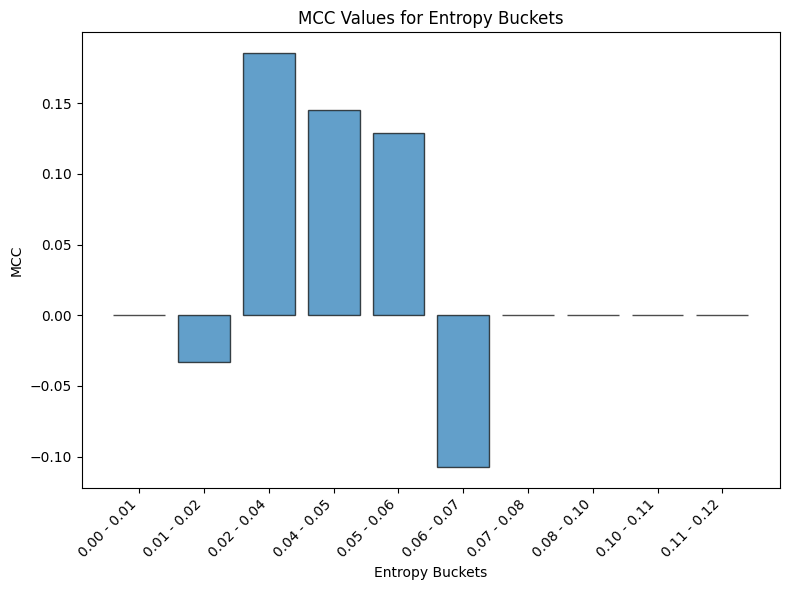

EPOCH END RESULTS MCC: 0.06385507898444517, LOW: 0.0, MED: 0.07690288519554891, HIGH: 0.043119188598730866
--------------------
epoch: 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.15469995141029358 mcc: 0.4526019054848144


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.16517335176467896 mcc: 0.43980055574359445


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.15770378708839417 mcc: 0.4472685035755276


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.3571387529373169 mcc: 0.49131390339175623


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.28955990076065063 mcc: 0.5095947152272561


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.24809204041957855 mcc: 0.47092376799672786


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.17630957067012787 mcc: 0.4676136016306099


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.1368369460105896 mcc: 0.4687183200503315


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.14340391755104065 mcc: 0.46633617132933625


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.15374639630317688 mcc: 0.44925823757690736


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.40018919110298157 mcc: 0.48056235748307635


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.14359089732170105 mcc: 0.4877627340158443


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.16354817152023315 mcc: 0.4698855858427727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.11840707808732986 mcc: 0.4685956944561118


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.1556670367717743 mcc: 0.4705980362264651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.18238502740859985 mcc: 0.4462757685636178


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.2685807943344116 mcc: 0.4761644824583057


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.2504505515098572 mcc: 0.49547526643886863


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.1733952760696411 mcc: 0.48282194676470847


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.13338099420070648 mcc: 0.4542502142429748


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.1483437716960907 mcc: 0.428101176569592


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.13885684311389923 mcc: 0.5335063908572539


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.3144950270652771 mcc: 0.4926381966415362


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.31209030747413635 mcc: 0.4408000097589248


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.20271557569503784 mcc: 0.4900207508771663


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.13192854821681976 mcc: 0.4736531614749897


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.12632423639297485 mcc: 0.47866689564676407


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.12336241453886032 mcc: 0.43772015233027856


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.11321371793746948 mcc: 0.4935593229713307


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.193153977394104 mcc: 0.47825016272306237


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.2500065565109253 mcc: 0.4285997870946865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.1754721701145172 mcc: 0.5362397372755622


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.022692084766092677, pvalue=0.6381120120953101)


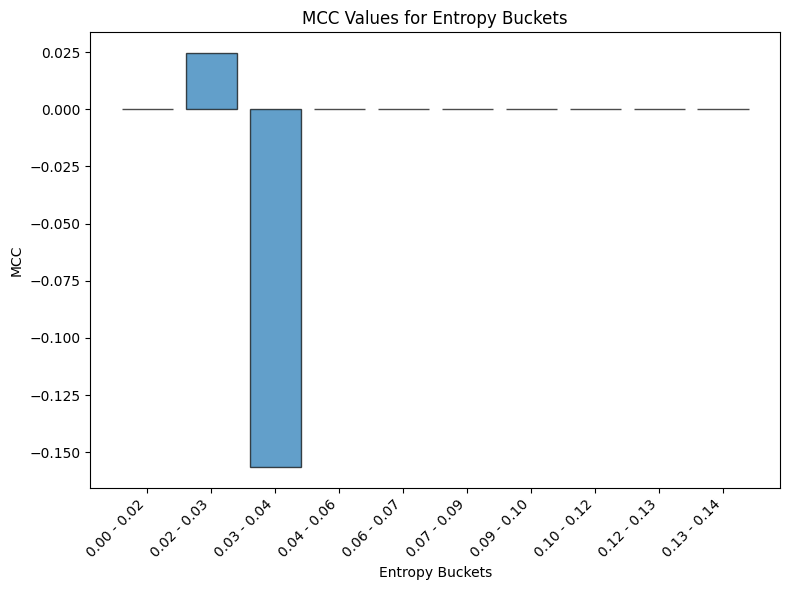

EPOCH END RESULTS MCC: -0.056626440864156566, LOW: 0.0, MED: 0.0, HIGH: -0.07292829519184492
--------------------
epoch: 2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.11036893725395203 mcc: 0.5141671091113803


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.16831500828266144 mcc: 0.488716188586762


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.1468883454799652 mcc: 0.4874947810614599


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.11754344403743744 mcc: 0.513571592179139


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.16209393739700317 mcc: 0.5234032066739182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.14734037220478058 mcc: 0.49386624714189853


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.2877901792526245 mcc: 0.46600393939151025


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.17664839327335358 mcc: 0.5134172807257702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.3779875636100769 mcc: 0.4834028586942502


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.16472800076007843 mcc: 0.4909985559327186


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.1898413598537445 mcc: 0.4909489566105062


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.14669206738471985 mcc: 0.5030710170140338


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.13428837060928345 mcc: 0.4758014094561838


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.2304861843585968 mcc: 0.5097077402954465


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.14086467027664185 mcc: 0.49139003211572957


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.17842823266983032 mcc: 0.5203497302100971


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.24418742954730988 mcc: 0.49806830108540356


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.33114299178123474 mcc: 0.5110040832771934


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.10941469669342041 mcc: 0.5060257720133365


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.27010828256607056 mcc: 0.5062479293763359


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.19714516401290894 mcc: 0.4782661454838455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.17791950702667236 mcc: 0.4845806723356639


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.14922131597995758 mcc: 0.5177666823427894


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.18386703729629517 mcc: 0.5135425105867608


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.2011590301990509 mcc: 0.516797982480507


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.15494702756404877 mcc: 0.5085059804610209


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.2949897050857544 mcc: 0.47184994954559856


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.17361509799957275 mcc: 0.4986482560079963


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.11705482006072998 mcc: 0.4786041404250727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.1782190203666687 mcc: 0.5039713204120417


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.23570898175239563 mcc: 0.5132954226526809


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.15922130644321442 mcc: 0.4992647091648091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.03795040642332467, pvalue=0.43140923500791717)


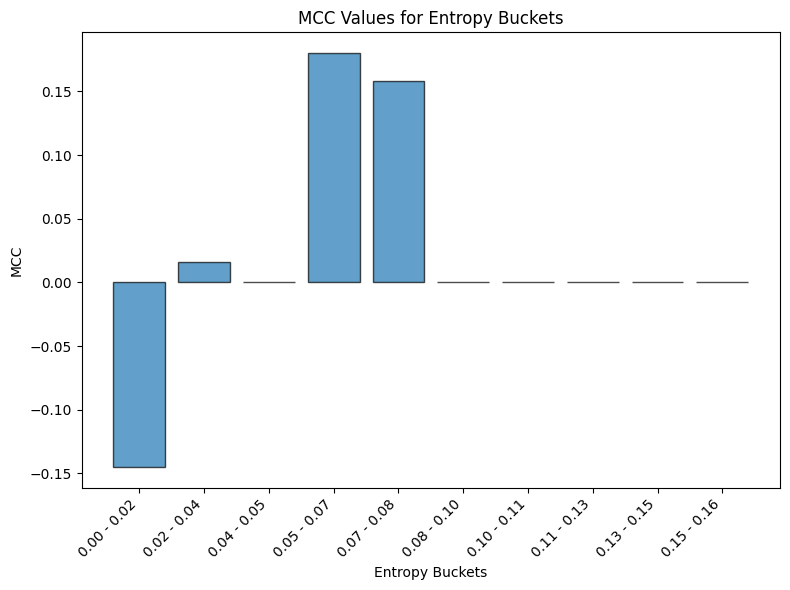

EPOCH END RESULTS MCC: 0.007362113474524828, LOW: 0.0, MED: 0.1369282081441797, HIGH: -0.05670189926600982
--------------------
epoch: 3


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.1456609070301056 mcc: 0.589872830909857


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.2787378430366516 mcc: 0.5238445177649295


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.23574724793434143 mcc: 0.4719008877292326


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.1484200358390808 mcc: 0.48030293348715647


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.13358166813850403 mcc: 0.49069352876685907


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.11069060862064362 mcc: 0.5229915665810477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.1406564712524414 mcc: 0.4744926142578793


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.1142813041806221 mcc: 0.5406432313595558


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.18366599082946777 mcc: 0.5046102789355781


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.13448664546012878 mcc: 0.5263862593342095


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.1380516141653061 mcc: 0.48045709346168647


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.22947576642036438 mcc: 0.4702521868578385


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.2635260224342346 mcc: 0.4485672818355316


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.16646139323711395 mcc: 0.5188978155102463


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.19029632210731506 mcc: 0.5372175819865935


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.12322060763835907 mcc: 0.5232850990362395


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.13932885229587555 mcc: 0.5384557785216132


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.2366461306810379 mcc: 0.5139154421804798


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.10369051247835159 mcc: 0.5175504252717965


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.23840957880020142 mcc: 0.4780702205261963


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.16723665595054626 mcc: 0.5159719777058783


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.20326033234596252 mcc: 0.4814596621755547


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.15543454885482788 mcc: 0.48381593045631804


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.23463597893714905 mcc: 0.523393730690984


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.22828873991966248 mcc: 0.5104432923959346


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.08792884647846222 mcc: 0.48686320976236824


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.20822957158088684 mcc: 0.503071059667759


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.12430756539106369 mcc: 0.5378253918888346


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.11999976634979248 mcc: 0.49719981391876594


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.26361072063446045 mcc: 0.5253414605306767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.08764559775590897 mcc: 0.5035333758032652


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.18773525953292847 mcc: 0.49485770851052535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.07495126810736508, pvalue=0.1198251719318954)


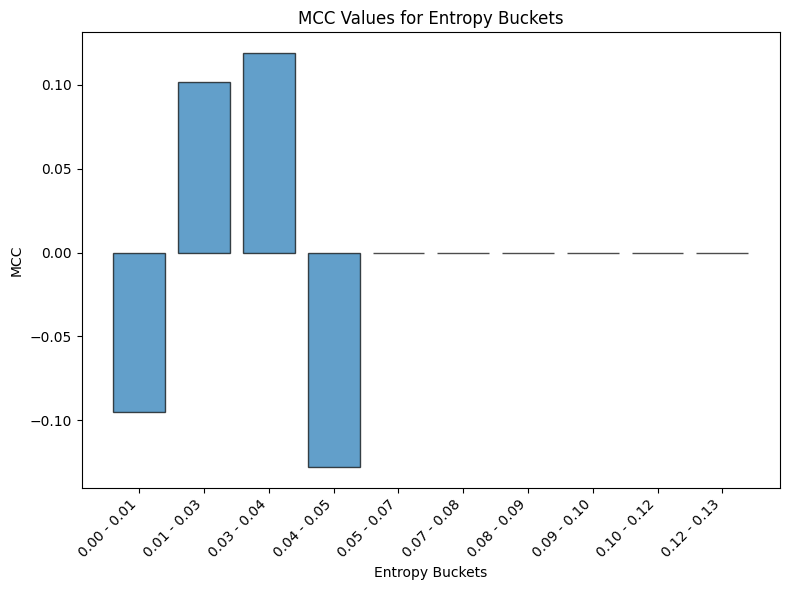

EPOCH END RESULTS MCC: 0.042357625275132156, LOW: 0.0, MED: -0.09352682224487927, HIGH: 0.09385699937342898
--------------------
epoch: 4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.19252654910087585 mcc: 0.15686368416817548


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.303275465965271 mcc: 0.5566126519911285


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.14127162098884583 mcc: 0.5215528172850935


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.10481943190097809 mcc: 0.5302872542643777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.16415640711784363 mcc: 0.4736948640537034


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.1993565559387207 mcc: 0.5056149569860702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.12416159361600876 mcc: 0.5341006033093595


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.13945378363132477 mcc: 0.5221217618050917


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.23664477467536926 mcc: 0.4898537253251981


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.153861403465271 mcc: 0.5073968605236119


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.12209131568670273 mcc: 0.5057644873515217


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.14146296679973602 mcc: 0.4981258650040612


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.17624159157276154 mcc: 0.5476290088683625


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.16002318263053894 mcc: 0.5347392210226927


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.17573678493499756 mcc: 0.4925629825532107


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.10034476220607758 mcc: 0.5168372914100393


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.24286502599716187 mcc: 0.529720996398544


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.2133059799671173 mcc: 0.511036558206834


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.1581023782491684 mcc: 0.5408312414272267


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.198531836271286 mcc: 0.5371225518899566


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.13421234488487244 mcc: 0.49980662115150726


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.13975758850574493 mcc: 0.5121231970084523


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.16703100502490997 mcc: 0.535576298380746


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.19731581211090088 mcc: 0.5630521345568054


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.19893623888492584 mcc: 0.5003869743786711


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.1583896279335022 mcc: 0.523543932083257


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.10378318279981613 mcc: 0.516397139153155


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.23078587651252747 mcc: 0.497461371290156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.15425927937030792 mcc: 0.47755363491580793


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.17948907613754272 mcc: 0.5358794577807637


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.1971157193183899 mcc: 0.5384720300533156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.11578890681266785 mcc: 0.5204831140821331


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.03720956452520665, pvalue=0.4404623751654749)


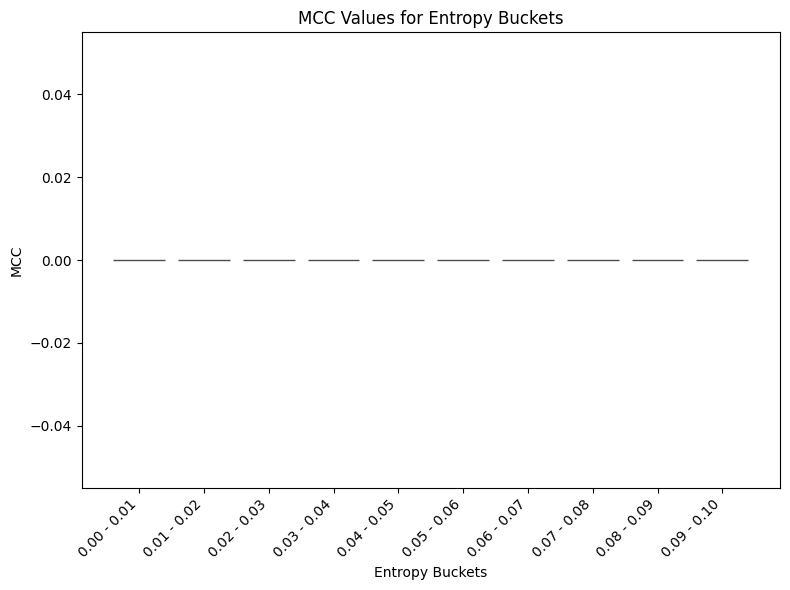

EPOCH END RESULTS MCC: 0.0, LOW: 0.0, MED: 0.0, HIGH: 0.0
--------------------
epoch: 5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.17376214265823364 mcc: 0.3670584895244009


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.12364163994789124 mcc: 0.5091092739417404


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.13591356575489044 mcc: 0.5486597902113796


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.25514310598373413 mcc: 0.498528034138429


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.10804347693920135 mcc: 0.5604750051822657


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.2184685468673706 mcc: 0.5196634147417066


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.18225592374801636 mcc: 0.5332830403874333


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.17696884274482727 mcc: 0.5192177906364037


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.10941822081804276 mcc: 0.504892238882009


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.11513088643550873 mcc: 0.5522939363104052


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.13088378310203552 mcc: 0.522464262280661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.12725022435188293 mcc: 0.494946024051715


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.13979145884513855 mcc: 0.517977889532718


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.07173015922307968 mcc: 0.554333411267285


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.17727461457252502 mcc: 0.5372562649757214


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.11341670900583267 mcc: 0.5239294754401027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.18905696272850037 mcc: 0.5666256131432944


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.11705966293811798 mcc: 0.5494543375338001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.22277072072029114 mcc: 0.5483826588994145


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.1260317713022232 mcc: 0.5207399329997212


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.17698746919631958 mcc: 0.5162752604682336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.17389820516109467 mcc: 0.5778266348869165


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.1542840301990509 mcc: 0.5103758054156553


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.2043513059616089 mcc: 0.4734328439245197


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.15574902296066284 mcc: 0.5031615326698435


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.10778501629829407 mcc: 0.56592773442332


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.1824278086423874 mcc: 0.5017740101289864


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.142537459731102 mcc: 0.48445271264016326


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.12935000658035278 mcc: 0.5491350542924016


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.24457091093063354 mcc: 0.5196465913622279


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.16304366290569305 mcc: 0.5078692163001868


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.16750206053256989 mcc: 0.5541397572002178


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.11920949497631259, pvalue=0.013160693891075515)


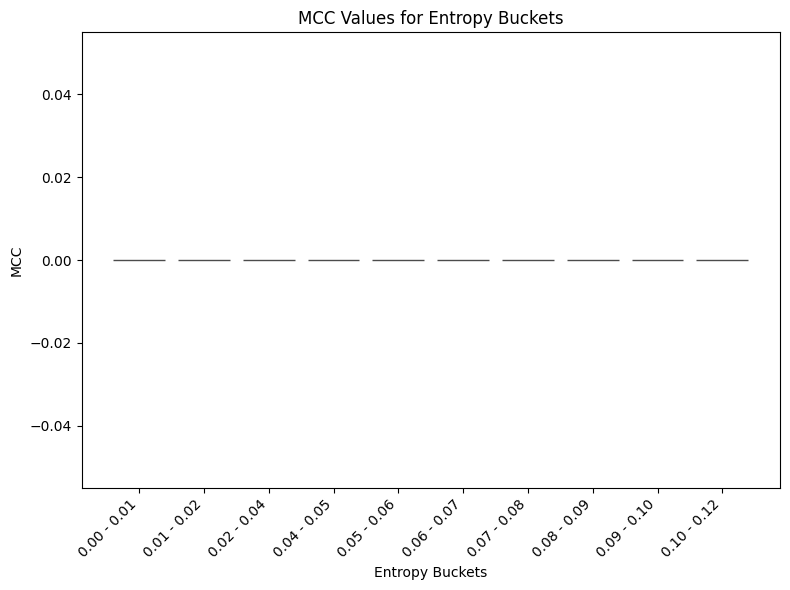

EPOCH END RESULTS MCC: 0.0, LOW: 0.0, MED: 0.0, HIGH: 0.0
--------------------
epoch: 6


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.13319125771522522 mcc: 0.52678658400752


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.12082906812429428 mcc: 0.5880700645787723


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.1459452211856842 mcc: 0.5183254217305542


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.13712361454963684 mcc: 0.5499782302465156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.09084625542163849 mcc: 0.5431652139581509


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.29733288288116455 mcc: 0.5492420333529413


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.20709580183029175 mcc: 0.5253570167865868


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.23244956135749817 mcc: 0.5601496127713163


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.1545906811952591 mcc: 0.5875262137843755


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.12487160414457321 mcc: 0.5268730846309704


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.12329374253749847 mcc: 0.5527861263980633


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.2735002338886261 mcc: 0.5430951058869995


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.17295584082603455 mcc: 0.532053921520109


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.14570900797843933 mcc: 0.5768476808420515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.3286142945289612 mcc: 0.5274760862187375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.15114526450634003 mcc: 0.5851788253566521


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.18809774518013 mcc: 0.5521862984228934


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.12552720308303833 mcc: 0.5605425768157368


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.1926046907901764 mcc: 0.5407361620872309


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.20592689514160156 mcc: 0.526535895144392


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.13786451518535614 mcc: 0.5623903783485408


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.10440271347761154 mcc: 0.5725537573060336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.1685478687286377 mcc: 0.4961240057371113


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.12559114396572113 mcc: 0.4956096443944898


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.14557130634784698 mcc: 0.5276060398004414


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.09558594226837158 mcc: 0.5694588119454994


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.0968327522277832 mcc: 0.5132345902199208


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.13212773203849792 mcc: 0.5499844862391604


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.17109528183937073 mcc: 0.520067185040995


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.1445314586162567 mcc: 0.5524413404803927


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.1836356818675995 mcc: 0.5627877876460046


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.19367624819278717 mcc: 0.5253521008179041


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.0970262202989089, pvalue=0.04384529359249849)


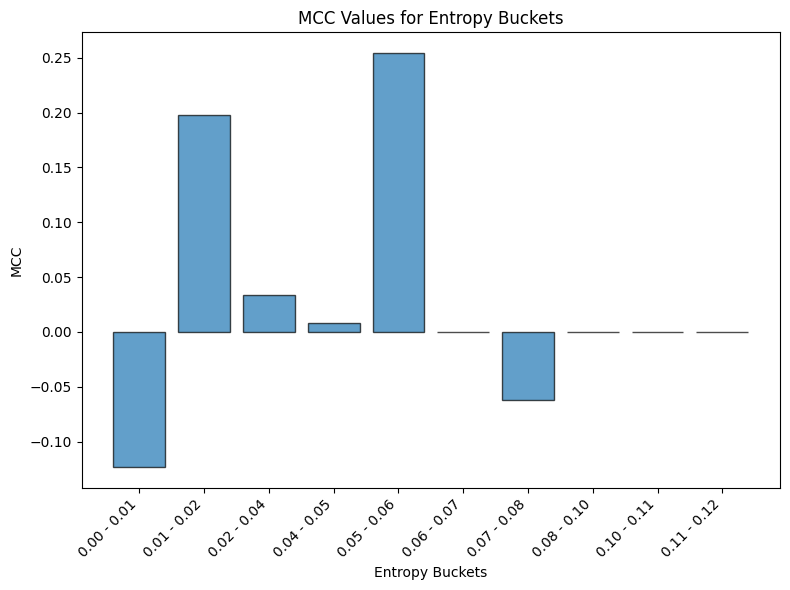

EPOCH END RESULTS MCC: 0.04960781300286804, LOW: 0.0, MED: 0.053139091992013755, HIGH: 0.04438401534164462
--------------------
epoch: 7


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.12988333404064178 mcc: 0.6637465183030647


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.22191733121871948 mcc: 0.5574987771857848


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.11672353744506836 mcc: 0.5788433415727511


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.16024193167686462 mcc: 0.4848115932249986


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.10826898366212845 mcc: 0.5231071711763742


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.0950152650475502 mcc: 0.5671790485958274


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.19186285138130188 mcc: 0.5426426046193513


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.19683626294136047 mcc: 0.5258932292019097


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.08597639203071594 mcc: 0.5521663188957918


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.24749499559402466 mcc: 0.5191819832504899


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.1203143447637558 mcc: 0.5188103183989985


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.10682074725627899 mcc: 0.5497993494053113


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.16814245283603668 mcc: 0.5528948548447944


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.4598757028579712 mcc: 0.5455857292953702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.10970446467399597 mcc: 0.5731661121264546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.12390300631523132 mcc: 0.5560922063367468


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.13517922163009644 mcc: 0.5871898037037495


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.18402162194252014 mcc: 0.5162061362759888


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.11857198178768158 mcc: 0.5773555959273974


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.21671593189239502 mcc: 0.5552507806174345


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.2977202534675598 mcc: 0.5400949647244219


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.15902988612651825 mcc: 0.5596054148181254


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.11879836022853851 mcc: 0.5446436399858796


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.11455774307250977 mcc: 0.5504759932836606


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.132080078125 mcc: 0.5098994460667862


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.09875466674566269 mcc: 0.5813219858460413


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.15482817590236664 mcc: 0.545447539463608


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.1830921620130539 mcc: 0.5469757299962209


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.11324678361415863 mcc: 0.5351501521590892


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.15778911113739014 mcc: 0.5464813317949744


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.11851640045642853 mcc: 0.5153962689777843


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.17017507553100586 mcc: 0.5436026964085621


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.054456842084976746, pvalue=0.25871943677729775)


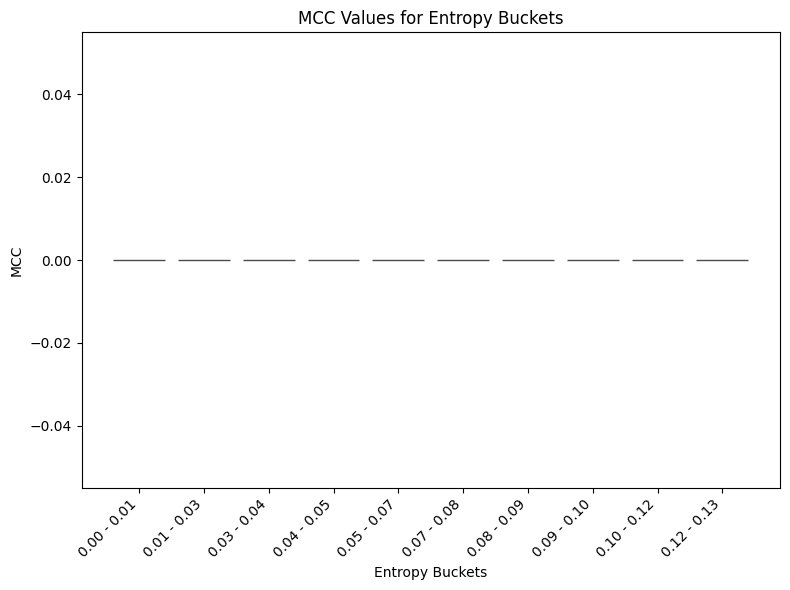

EPOCH END RESULTS MCC: 0.0, LOW: 0.0, MED: 0.0, HIGH: 0.0
--------------------
epoch: 8


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.16211530566215515 mcc: 0.5447047794019222


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.13893774151802063 mcc: 0.5710905158716368


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.10537174344062805 mcc: 0.5460382601751723


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.12634490430355072 mcc: 0.5388773541938965


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.13507451117038727 mcc: 0.5528252568330856


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.10213550925254822 mcc: 0.5796968834265954


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.15798112750053406 mcc: 0.562410335040516


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.20756646990776062 mcc: 0.5954022098807469


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.14756575226783752 mcc: 0.5733431869854289


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.2629874348640442 mcc: 0.5493178043650112


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.2508653402328491 mcc: 0.6139033203028404


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.12799307703971863 mcc: 0.5382432701521879


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.13820108771324158 mcc: 0.5667540703365136


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.1340995579957962 mcc: 0.5675766646805904


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.1623586118221283 mcc: 0.5387945116503488


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.14934343099594116 mcc: 0.5572054717679508


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.14632369577884674 mcc: 0.5527583039260031


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.09285011142492294 mcc: 0.5480480339317726


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.11953538656234741 mcc: 0.5707622286008294


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.17825624346733093 mcc: 0.5810965105031879


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.11973239481449127 mcc: 0.5824334060657702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.06915201246738434 mcc: 0.6041307270854922


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.1495940238237381 mcc: 0.5213240553435738


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.16535763442516327 mcc: 0.5389262336100037


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.17042416334152222 mcc: 0.5276456129583026


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.13191348314285278 mcc: 0.5305399281327325


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.1178758442401886 mcc: 0.5526579320981004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.15549775958061218 mcc: 0.5667638346965141


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.14063988626003265 mcc: 0.5424151152280473


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.254036545753479 mcc: 0.5523957828141092


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.1091727465391159 mcc: 0.5616555718239351


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.09122566878795624 mcc: 0.5703537395739863


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.1298724430319475, pvalue=0.006872015491136148)


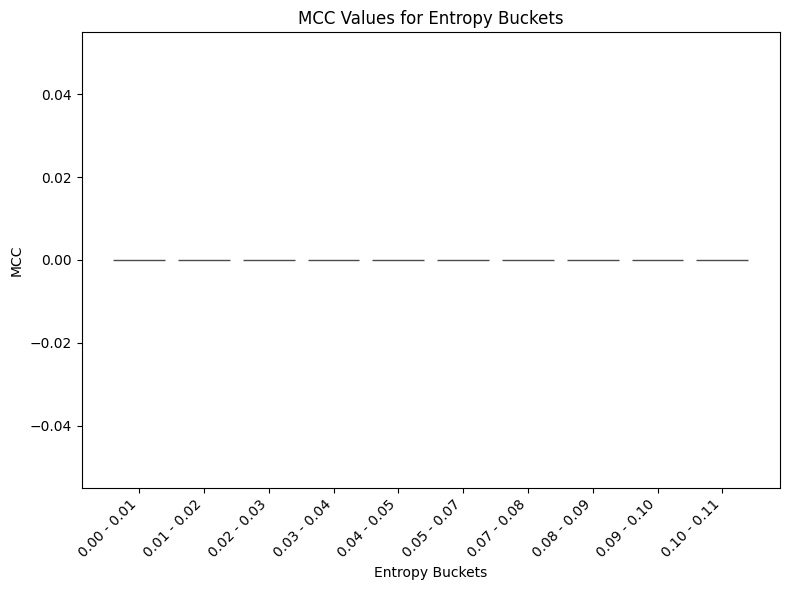

EPOCH END RESULTS MCC: 0.0, LOW: 0.0, MED: 0.0, HIGH: 0.0
--------------------
epoch: 9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1595 loss: 0.11514774709939957 mcc: 0.6078306738548308


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1595 loss: 0.11294291913509369 mcc: 0.6035502993279317


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1595 loss: 0.1375242918729782 mcc: 0.5807546996703462


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1595 loss: 0.16826891899108887 mcc: 0.5686055658142238


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1595 loss: 0.18396633863449097 mcc: 0.6220103995637384


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1595 loss: 0.15992575883865356 mcc: 0.5672207772922527


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1595 loss: 0.12601272761821747 mcc: 0.5632424183237439


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1595 loss: 0.1428024172782898 mcc: 0.5304404813163723


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1595 loss: 0.2284291535615921 mcc: 0.5762228464760129


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1595 loss: 0.16241766512393951 mcc: 0.5729278256063204


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1595 loss: 0.09908753633499146 mcc: 0.6010097152372377


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1595 loss: 0.11228658258914948 mcc: 0.5372266771036844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1595 loss: 0.16793201863765717 mcc: 0.5686369143050828


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1595 loss: 0.1343575417995453 mcc: 0.6005081171809011


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1595 loss: 0.1444089114665985 mcc: 0.5802116430051576


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1595 loss: 0.11971162259578705 mcc: 0.5595770463038152


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1595 loss: 0.1630200743675232 mcc: 0.5739302897250299


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1595 loss: 0.10930228233337402 mcc: 0.5248175247541406


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1595 loss: 0.26410984992980957 mcc: 0.5442132065105293


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1595 loss: 0.1258019357919693 mcc: 0.5424041653824075


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1595 loss: 0.14593076705932617 mcc: 0.5645606293531249


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1595 loss: 0.11154744029045105 mcc: 0.5984033712099331


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1595 loss: 0.09214708209037781 mcc: 0.5534552594148704


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1595 loss: 0.14354689419269562 mcc: 0.5301106482643617


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1595 loss: 0.08770059049129486 mcc: 0.5935774595980784


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1595 loss: 0.16818109154701233 mcc: 0.5966467182172727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1595 loss: 0.1079772561788559 mcc: 0.5952822677406687


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1595 loss: 0.09750097990036011 mcc: 0.570437377793798


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1595 loss: 0.16517530381679535 mcc: 0.5467714660704636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1595 loss: 0.1590804159641266 mcc: 0.5566509660853698


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1595 loss: 0.13635681569576263 mcc: 0.5786372140792002


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1595 loss: 0.22768159210681915 mcc: 0.5212665313004661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.11711699213959177, pvalue=0.014868546553218847)


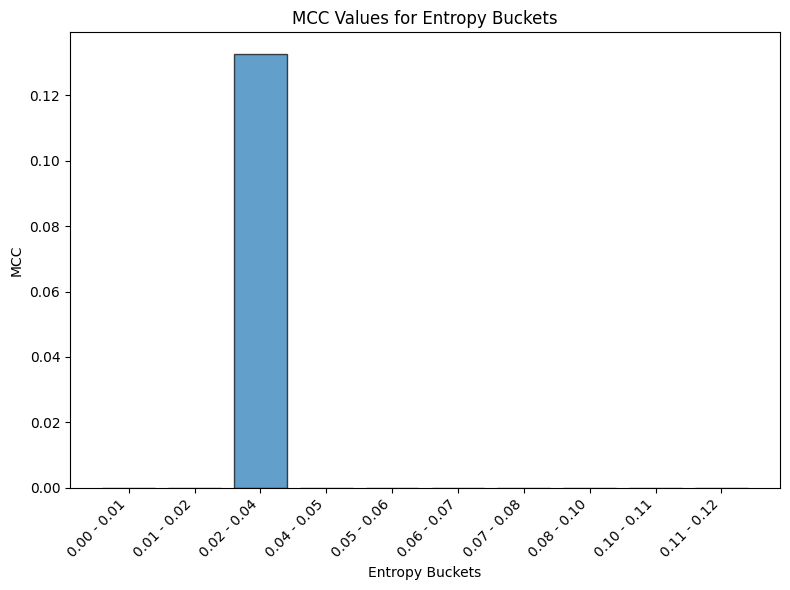

EPOCH END RESULTS MCC: 0.05893702302884445, LOW: 0.0, MED: 0.0, HIGH: 0.06763728922813676
Finished fold: 7
BEST {'mcc': 0.06385507898444517, 'low_mcc': 0.0, 'med_mcc': 0.07690288519554891, 'high_mcc': 0.043119188598730866, 'set_name': 'SG_SET_V5_XTB_STANDARDIZED_aminotransferase_binary.pkl', 'std_devs': array([0.05165535, 0.06141062, 0.07527457, 0.06082421, 0.0496649 ,
       0.05324315, 0.05868624, 0.06380297, 0.0143296 , 0.01306172,
       0.0314052 , 0.05303357, 0.02662358, 0.01115836, 0.0249154 ,
       0.03514609, 0.03167354, 0.03356976, 0.02335328, 0.01619077,
       0.02922109, 0.01775535, 0.01202975, 0.01663869, 0.02612758,
       0.0141349 , 0.04108575, 0.02449502, 0.03712438, 0.02083956,
       0.02511591, 0.02390477, 0.02116471, 0.01335367, 0.03180049,
       0.02759916, 0.03515283, 0.05653275, 0.073638  , 0.06186131,
       0.04876516, 0.04904258, 0.06022793, 0.05383661, 0.04318723,
       0.03101902, 0.04486259, 0.05834517, 0.03618973, 0.02447242,
       0.02944757, 0.0398

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.4037790298461914 mcc: -0.4042260417272216


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.31614813208580017 mcc: 0.07355606362083737


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.26034578680992126 mcc: 0.11828776500801182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.26676976680755615 mcc: 0.14467362191986202


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.2958853244781494 mcc: 0.21538636485352514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.21153594553470612 mcc: 0.2438097401733152


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.19420358538627625 mcc: 0.30152582094378455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.15969218313694 mcc: 0.3655434353219955


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.24927347898483276 mcc: 0.30748883664329035


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.26764625310897827 mcc: 0.3563425826144162


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.15777604281902313 mcc: 0.369464033467244


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.26879405975341797 mcc: 0.3614696928395308


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.1802123486995697 mcc: 0.3924092303110257


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.17243394255638123 mcc: 0.39830429569648756


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.18226751685142517 mcc: 0.37666067276522497


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.21091040968894958 mcc: 0.3730831925969354


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.2536425292491913 mcc: 0.4152501737992306


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.2773120701313019 mcc: 0.4312772356311991


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.17684528231620789 mcc: 0.40125058597501573


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.22254958748817444 mcc: 0.3939146450844661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.20661690831184387 mcc: 0.4529637592331977


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.20115047693252563 mcc: 0.4452943472918068


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.3326846957206726 mcc: 0.4082620686128623


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.3741360902786255 mcc: 0.4319525062747901


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.1397325098514557 mcc: 0.44774320639219545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.32515689730644226 mcc: 0.4251554662915178


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.22748464345932007 mcc: 0.4230758803240756


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.2679820656776428 mcc: 0.41701615036806366


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.38794296979904175 mcc: 0.4428010768857854


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.3294956088066101 mcc: 0.4499291547043932


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.3493872284889221 mcc: 0.4304126894308696


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.15739020705223083 mcc: 0.37846497700612575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.2088789091268748, pvalue=4.627120563111172e-08)


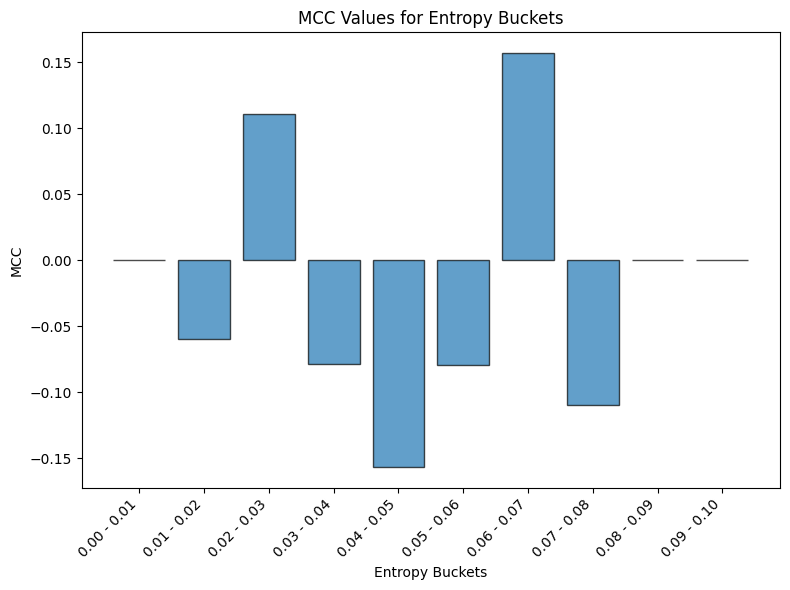

EPOCH END RESULTS MCC: -0.005649953313247477, LOW: -0.23452078799117146, MED: 0.054458128262910896, HIGH: -0.017712378738228247
--------------------
epoch: 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.15304677188396454 mcc: 0.6382847385042254


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.17026647925376892 mcc: 0.48254577571449814


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.1330515295267105 mcc: 0.48191903352498816


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.17018185555934906 mcc: 0.4432613553095382


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.1559644192457199 mcc: 0.4914999025096097


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.2293003648519516 mcc: 0.4402323046811896


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.16680680215358734 mcc: 0.4602595321080556


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.1400638073682785 mcc: 0.4875571348784059


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.3039461374282837 mcc: 0.4542035854375736


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.24270230531692505 mcc: 0.4779806735256631


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.32431232929229736 mcc: 0.4762574164041756


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.21469223499298096 mcc: 0.4282279673869947


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.2807011008262634 mcc: 0.467193902037344


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.2834986746311188 mcc: 0.46675350267346377


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.29619309306144714 mcc: 0.49656757980088373


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.12038183957338333 mcc: 0.4984348243010064


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.19701746106147766 mcc: 0.5021346970375293


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.19730889797210693 mcc: 0.4369489800950869


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.1745670735836029 mcc: 0.4958770700346941


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.15200529992580414 mcc: 0.4592918068100252


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.15330807864665985 mcc: 0.4898292931242164


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.24077613651752472 mcc: 0.4710263539283281


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.19159743189811707 mcc: 0.46195297315109096


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.20789526402950287 mcc: 0.48520877625241693


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.16795718669891357 mcc: 0.49874934490987444


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.1761232167482376 mcc: 0.5084205177787481


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.1725997030735016 mcc: 0.47926238155116396


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.15147501230239868 mcc: 0.4860762634413639


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.18159638345241547 mcc: 0.47699696004335895


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.18786180019378662 mcc: 0.4504801301843391


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.1555408239364624 mcc: 0.4049315499001971


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.1276826411485672 mcc: 0.5144141276697505


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.04619012979204762, pvalue=0.23177691089037675)


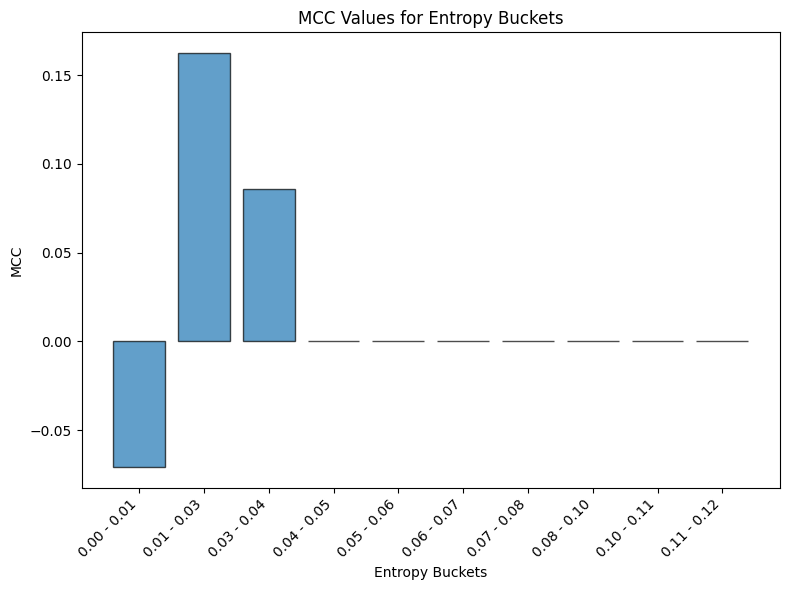

EPOCH END RESULTS MCC: 0.06106236077756591, LOW: 0.0, MED: 0.0, HIGH: 0.07896100525895697
--------------------
epoch: 2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.22921155393123627 mcc: 0.5204956780951701


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.1373976767063141 mcc: 0.49701547586238387


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.2136194407939911 mcc: 0.476436980288345


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.20491380989551544 mcc: 0.4589101469269756


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.2726425528526306 mcc: 0.48124837261437636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.13545718789100647 mcc: 0.5097925153110916


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.1736450046300888 mcc: 0.4932026361981145


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.14235687255859375 mcc: 0.528629595463451


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.18687281012535095 mcc: 0.493307151005788


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.27715596556663513 mcc: 0.533633303571572


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.31376931071281433 mcc: 0.4942587996468223


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.2274613231420517 mcc: 0.4711256246699265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.17625203728675842 mcc: 0.4535603764421389


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.3085004687309265 mcc: 0.5026407669288872


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.14801278710365295 mcc: 0.4676396289165397


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.2038448452949524 mcc: 0.5015587455493853


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.18113285303115845 mcc: 0.48074887155152546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.23277871310710907 mcc: 0.5247712900710071


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.17669042944908142 mcc: 0.46324164620983027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.12648335099220276 mcc: 0.4962326911617496


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.1640596091747284 mcc: 0.4906284909901958


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.39388567209243774 mcc: 0.5362503795318022


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.35102909803390503 mcc: 0.5321652095275786


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.199258491396904 mcc: 0.5178358130570082


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.1343245804309845 mcc: 0.4969142302794086


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.12746495008468628 mcc: 0.5058185726236681


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.158905029296875 mcc: 0.502287061314219


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.13833387196063995 mcc: 0.5062244776347327


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.18700623512268066 mcc: 0.5303732794618152


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.17522692680358887 mcc: 0.4993361812372821


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.1779189258813858 mcc: 0.4831704887690517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.20759151875972748 mcc: 0.502483997531087


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.07687739180213846, pvalue=0.04635696379334813)


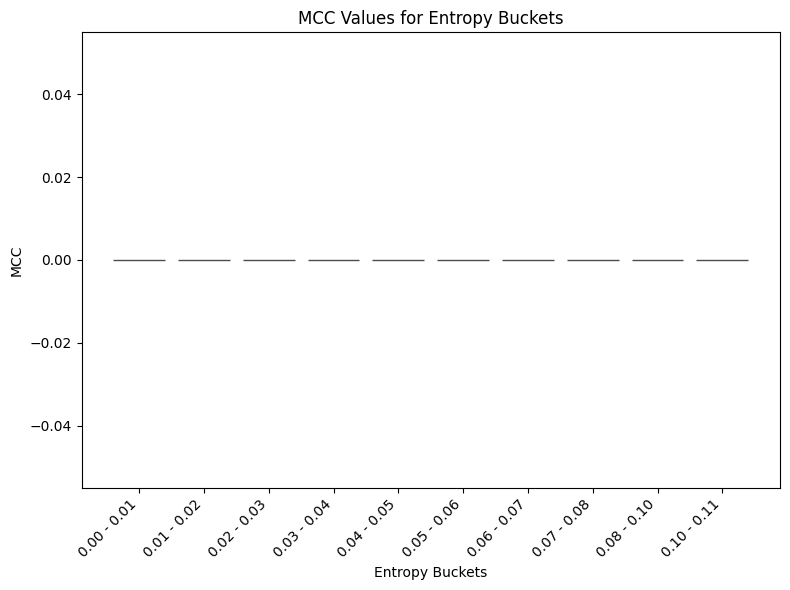

EPOCH END RESULTS MCC: 0.0, LOW: 0.0, MED: 0.0, HIGH: 0.0
--------------------
epoch: 3


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.13776296377182007 mcc: 0.41179801403140964


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.18683293461799622 mcc: 0.48387164108711056


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.18028239905834198 mcc: 0.5263261589835638


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.1652451753616333 mcc: 0.4720373109844941


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.12817640602588654 mcc: 0.548033137806565


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.12379510700702667 mcc: 0.5309699676738813


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.13152943551540375 mcc: 0.5387368260827654


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.12443357706069946 mcc: 0.5019335972384719


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.22538131475448608 mcc: 0.5349100548590799


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.15852904319763184 mcc: 0.5263601378178914


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.1487654149532318 mcc: 0.4845163090542452


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.18208737671375275 mcc: 0.5015425837017343


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.18751174211502075 mcc: 0.49166006650435895


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.11524105072021484 mcc: 0.5097100832963104


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.13290441036224365 mcc: 0.5196880407603615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.2131975293159485 mcc: 0.5024851400551897


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.20539447665214539 mcc: 0.5182622237353459


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.17125952243804932 mcc: 0.45460473881187025


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.25423115491867065 mcc: 0.5173753171511298


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.26962244510650635 mcc: 0.4625460538463366


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.17131340503692627 mcc: 0.5175968538757748


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.22494091093540192 mcc: 0.5243543139347571


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.15626206994056702 mcc: 0.5123915086051706


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.1995605230331421 mcc: 0.5159115972487865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.23697946965694427 mcc: 0.48666886730112735


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.1870242953300476 mcc: 0.5301774559169629


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.14936132729053497 mcc: 0.49953874703381074


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.15961432456970215 mcc: 0.5235978392644913


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.17552587389945984 mcc: 0.5216888616890722


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.2517490088939667 mcc: 0.5043389243408061


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.1161423772573471 mcc: 0.5053306120578377


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.24482963979244232 mcc: 0.4952585770378514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.006263914124599025, pvalue=0.8712440373478333)


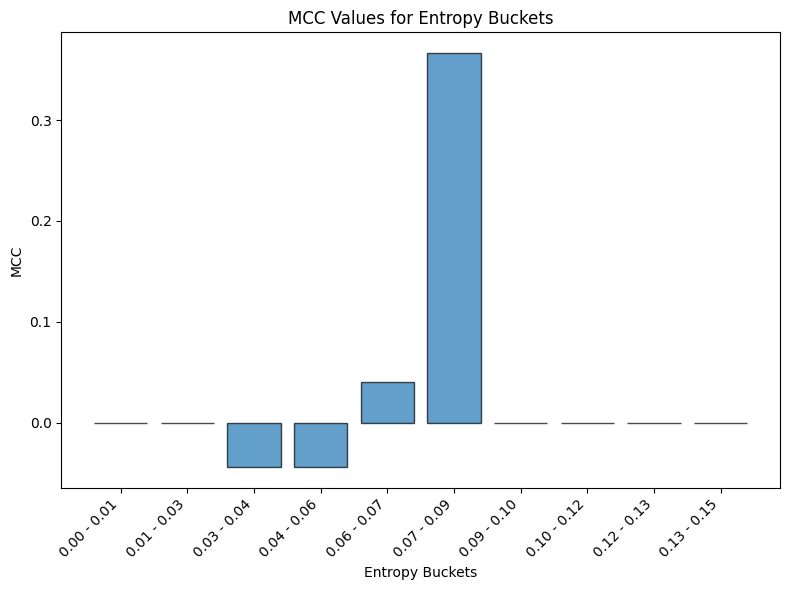

EPOCH END RESULTS MCC: 0.026798614536830183, LOW: 0.26967994498529685, MED: 0.10181456533837839, HIGH: -0.024663015722495917
--------------------
epoch: 4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.21621717512607574 mcc: 0.4133804997216296


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.1424703150987625 mcc: 0.5104566151318439


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.16001129150390625 mcc: 0.5169043724114284


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.13612835109233856 mcc: 0.5246522710096084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.11727055162191391 mcc: 0.5260773452542251


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.13039331138134003 mcc: 0.5597662212253927


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.27897101640701294 mcc: 0.510057783325908


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.17632421851158142 mcc: 0.4872552262803763


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.2620711028575897 mcc: 0.5299459781733665


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.09925984591245651 mcc: 0.5075571711136002


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.15788933634757996 mcc: 0.5078956706483795


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.1707269549369812 mcc: 0.5066134920809174


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.1427413523197174 mcc: 0.523747361325352


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.1423945426940918 mcc: 0.5153292049974669


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.15567374229431152 mcc: 0.566303219139311


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.18966741859912872 mcc: 0.5024597106893776


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.15488648414611816 mcc: 0.518932847452317


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.13263759016990662 mcc: 0.5137380945046881


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.13706311583518982 mcc: 0.557813431527538


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.12062818557024002 mcc: 0.49111865627819307


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.13409550487995148 mcc: 0.5369206885662247


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.20840613543987274 mcc: 0.5713079844345472


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.1769450306892395 mcc: 0.5703830713606804


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.15849243104457855 mcc: 0.5223770463040278


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.22232215106487274 mcc: 0.5336136319614905


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.15877847373485565 mcc: 0.5363289596776808


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.19068506360054016 mcc: 0.50317733778446


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.15468209981918335 mcc: 0.48797305458464046


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.13871127367019653 mcc: 0.5117890005195164


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.22254028916358948 mcc: 0.5249711989377394


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.10352233052253723 mcc: 0.5137140852184078


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.10958132892847061 mcc: 0.508346734851274


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.1349723779093604, pvalue=0.00045074878247840895)


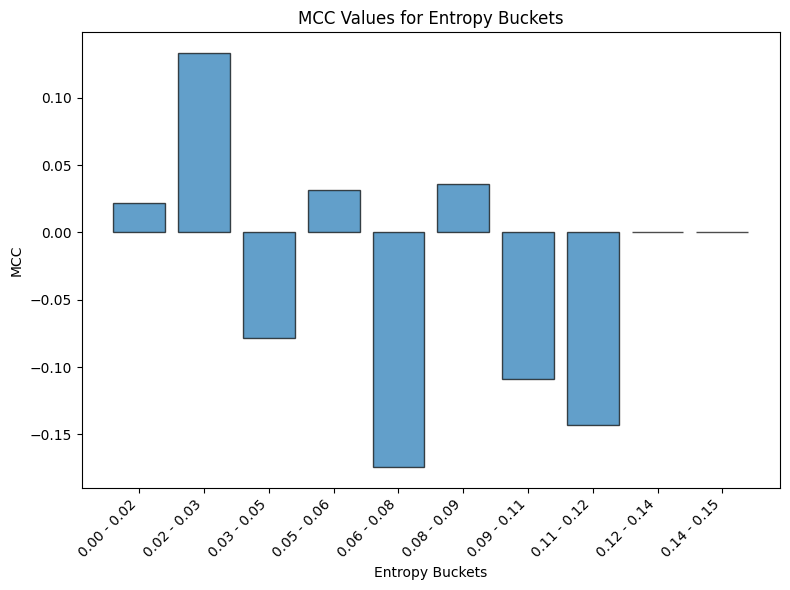

EPOCH END RESULTS MCC: -0.01609503946169222, LOW: 0.0, MED: -0.10404161737538838, HIGH: 0.0784464540552736
--------------------
epoch: 5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.14585383236408234 mcc: 0.5606119105813882


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.15126048028469086 mcc: 0.5181256871923114


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.35864388942718506 mcc: 0.5460750912008702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.17262491583824158 mcc: 0.5685671791265637


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.14951732754707336 mcc: 0.5364508370663141


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.1384926736354828 mcc: 0.5301355339779199


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.19085419178009033 mcc: 0.5399506796516865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.1866895705461502 mcc: 0.5811931397007829


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.21890494227409363 mcc: 0.5499257547663636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.10381759703159332 mcc: 0.551041702300672


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.11882198601961136 mcc: 0.553711583807309


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.16262125968933105 mcc: 0.5328490774305836


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.08750051259994507 mcc: 0.5095258235944525


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.27756381034851074 mcc: 0.5070552629467653


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.13229313492774963 mcc: 0.5699254592504472


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.1646604835987091 mcc: 0.5212510523360575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.24228450655937195 mcc: 0.4897763082243545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.11513552814722061 mcc: 0.5117135566659433


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.13673540949821472 mcc: 0.5197861418178162


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.18645498156547546 mcc: 0.5262002507221597


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.11162571609020233 mcc: 0.544347266833259


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.10236471891403198 mcc: 0.48296242248136445


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.15153831243515015 mcc: 0.48207494400850254


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.09101425111293793 mcc: 0.5199997456855145


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.1596514731645584 mcc: 0.5511071228950815


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.12957602739334106 mcc: 0.5175330071929847


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.21181558072566986 mcc: 0.5266056399240232


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.2238796353340149 mcc: 0.5042871756095993


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.17614611983299255 mcc: 0.5587548454546573


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.11697513610124588 mcc: 0.5292091312264288


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.16690874099731445 mcc: 0.526376600390075


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.13547974824905396 mcc: 0.5691871108717418


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.01938567768349528, pvalue=0.6159167189246936)


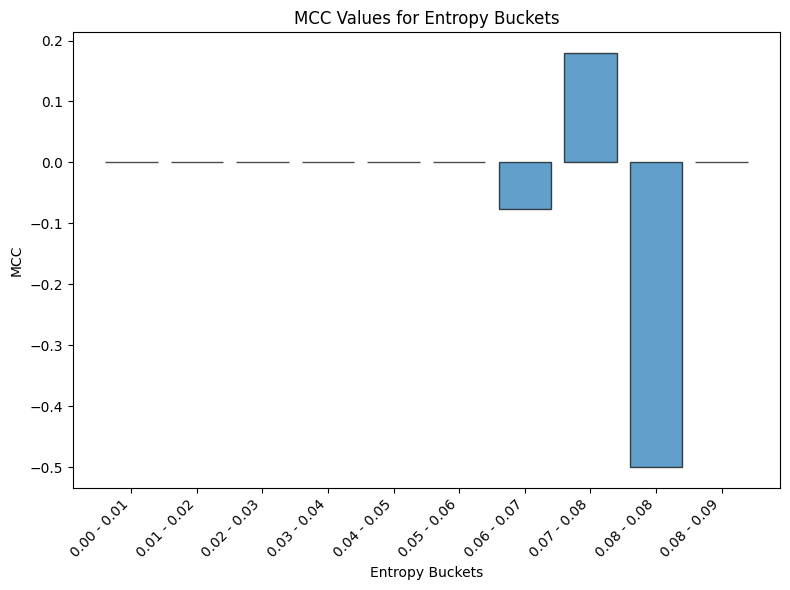

EPOCH END RESULTS MCC: 0.01294573859419529, LOW: 0.0, MED: 0.11430350442978263, HIGH: 0.0
--------------------
epoch: 6


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.11486281454563141 mcc: 0.477059961531621


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.1256013959646225 mcc: 0.6150510049091716


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.1971805989742279 mcc: 0.5551664002542265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.148405522108078 mcc: 0.5423145351470227


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.1271904855966568 mcc: 0.562842185436553


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.24112099409103394 mcc: 0.500390485741949


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.12289319187402725 mcc: 0.5535487771682325


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.21356414258480072 mcc: 0.5381337330949074


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.11771686375141144 mcc: 0.5267668549903308


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.11960606276988983 mcc: 0.5112853656015848


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.294137179851532 mcc: 0.5508951368028993


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.2293034791946411 mcc: 0.5493594107507727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.18062786757946014 mcc: 0.5646498635824786


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.17951321601867676 mcc: 0.4864944145004761


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.12427438795566559 mcc: 0.5643131832168132


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.3310147523880005 mcc: 0.5122613621416284


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.14554259181022644 mcc: 0.5513591027623205


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.2189774513244629 mcc: 0.5766369448265813


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.14987069368362427 mcc: 0.5408679240302268


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.15533670783042908 mcc: 0.5242585085563373


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.16217243671417236 mcc: 0.5235994703008806


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.10938650369644165 mcc: 0.5432223527232553


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.20598208904266357 mcc: 0.5010178157799628


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.16190382838249207 mcc: 0.514014881306035


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.17169226706027985 mcc: 0.5496586999765553


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.09315474331378937 mcc: 0.5453354592695266


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.16018787026405334 mcc: 0.5274546277641443


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.1342892050743103 mcc: 0.5055734747660958


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.10412834584712982 mcc: 0.5191086673708485


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.1542707085609436 mcc: 0.5601652993271957


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.08702383935451508 mcc: 0.5373020615154083


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.14440003037452698 mcc: 0.5270243221096184


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.09186144436320898, pvalue=0.01722238113258817)


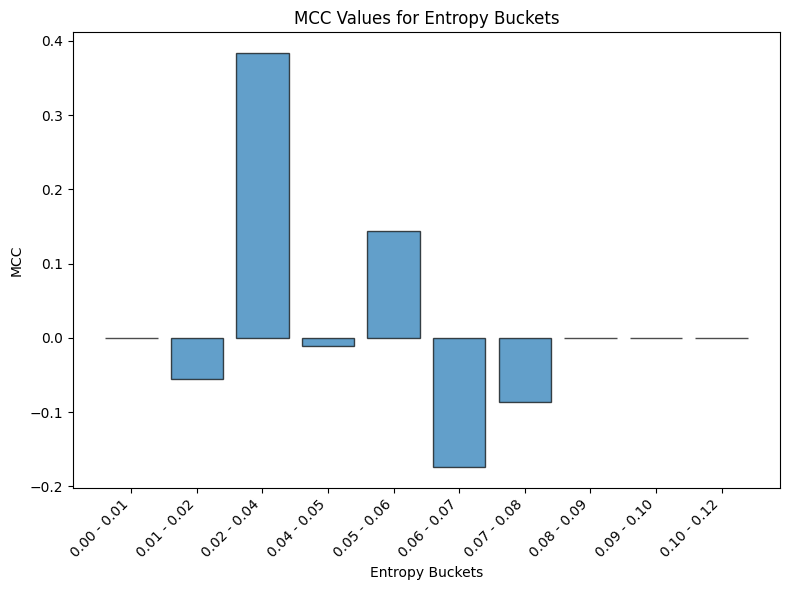

EPOCH END RESULTS MCC: 0.007469194583455559, LOW: -0.09325048082403138, MED: -0.03251194525429989, HIGH: 0.04870253430597549
--------------------
epoch: 7


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.14981397986412048 mcc: 0.34848958634343635


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.22633413970470428 mcc: 0.5527801808374909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.11525779962539673 mcc: 0.5530109927888817


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.2788073420524597 mcc: 0.5425492187210732


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.20587477087974548 mcc: 0.5237554144059846


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.1255667507648468 mcc: 0.5516762970553891


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.14965064823627472 mcc: 0.5884039825842317


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.1619662344455719 mcc: 0.5652879583005797


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.13159233331680298 mcc: 0.524000982599803


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.08711723983287811 mcc: 0.5295423186882546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.07693749666213989 mcc: 0.5558679638427555


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.15050703287124634 mcc: 0.5871701529292301


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.14966818690299988 mcc: 0.5702375952406276


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.07859653234481812 mcc: 0.5760143056453144


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.21831518411636353 mcc: 0.5347218818660994


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.15123137831687927 mcc: 0.5622917302731165


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.13755813241004944 mcc: 0.5547017615314572


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.15149156749248505 mcc: 0.5816296898456367


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.11322415620088577 mcc: 0.5831580602650358


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.14440283179283142 mcc: 0.5360440375101346


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.11875377595424652 mcc: 0.5884247221893255


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.19438567757606506 mcc: 0.5226390836126397


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.1652628779411316 mcc: 0.5622478831056584


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.12476670742034912 mcc: 0.5692110314403839


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.1921452134847641 mcc: 0.5053710159905315


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.15338286757469177 mcc: 0.5751938164561212


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.10295851528644562 mcc: 0.5699427326786852


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.07540521770715714 mcc: 0.5453941893871326


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.2236676812171936 mcc: 0.5393613048875705


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.11210288107395172 mcc: 0.5157431158324424


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.13266955316066742 mcc: 0.6008272229713447


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.13812769949436188 mcc: 0.5329735714221219


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.04237213372181155, pvalue=0.2727030500537203)


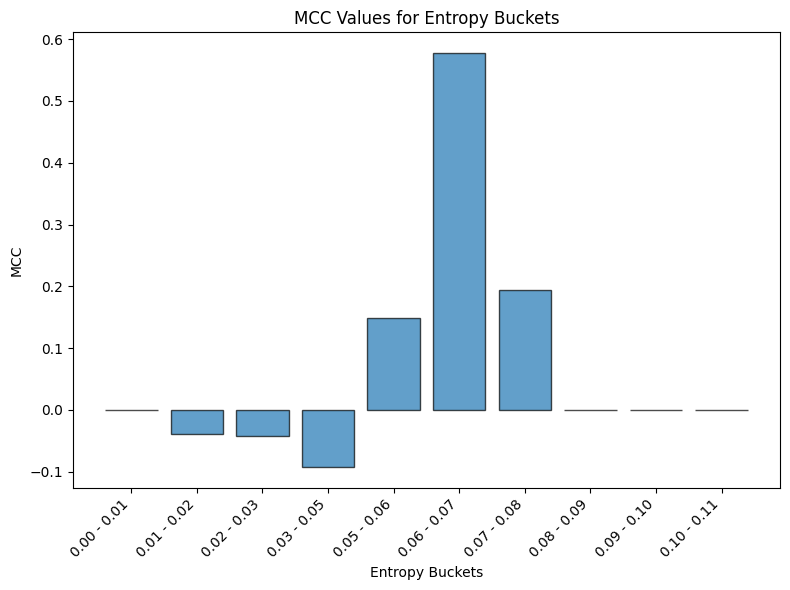

EPOCH END RESULTS MCC: 0.04682914396550772, LOW: 0.0, MED: 0.2209761975077013, HIGH: -0.03571844571341236
--------------------
epoch: 8


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.23046672344207764 mcc: 0.5362318840579711


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.15695714950561523 mcc: 0.5677368646945452


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.1389121562242508 mcc: 0.5698320882432839


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.12025832384824753 mcc: 0.6156534562949716


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.29696208238601685 mcc: 0.5614096763639022


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.19130967557430267 mcc: 0.624898837660394


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.3205166757106781 mcc: 0.5830472114143778


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.12396354228258133 mcc: 0.563486145831507


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.16770052909851074 mcc: 0.5396343086362813


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.2069694995880127 mcc: 0.5729767659220649


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.231885626912117 mcc: 0.556456911782447


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.13713403046131134 mcc: 0.5817023938512261


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.2992984652519226 mcc: 0.5359963267479186


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.2051512748003006 mcc: 0.5287239454076134


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.16647404432296753 mcc: 0.5422547381105671


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.10710619390010834 mcc: 0.5170968596314096


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.1240587830543518 mcc: 0.5512035675071929


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.11022517085075378 mcc: 0.5532761101465234


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.23052968084812164 mcc: 0.573737731732156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.1797308474779129 mcc: 0.5646088261064467


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.2509061098098755 mcc: 0.5749037181958804


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.15437732636928558 mcc: 0.5250071755067934


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.10777942836284637 mcc: 0.5845915183065785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.13876378536224365 mcc: 0.5333986103871766


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.2121569663286209 mcc: 0.5726193878120068


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.1412356197834015 mcc: 0.545232653477927


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.09175477921962738 mcc: 0.5906924234464431


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.18417154252529144 mcc: 0.5621983605053272


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.1442779004573822 mcc: 0.5688876363230133


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.1364351511001587 mcc: 0.5401153379048041


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.13392138481140137 mcc: 0.5640667456333329


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.2382516711950302 mcc: 0.5819206000450702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.029193254522967588, pvalue=0.44993236703966283)


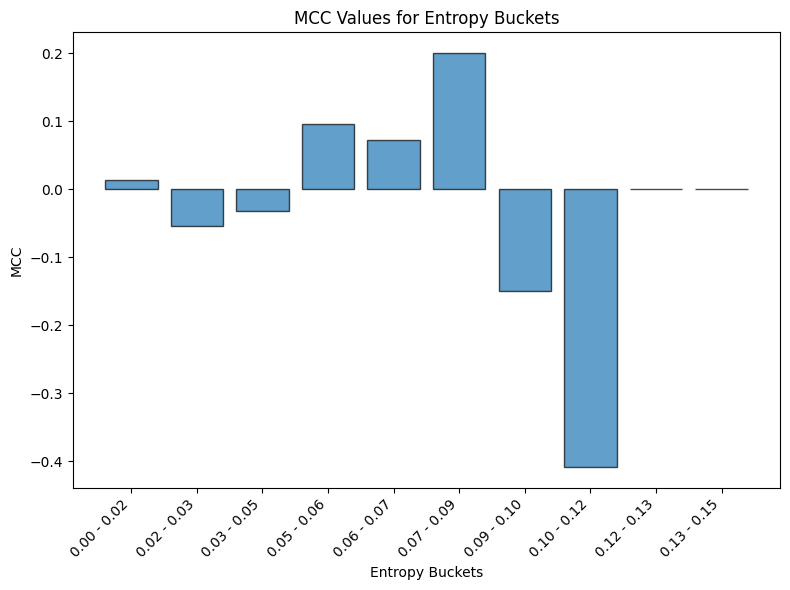

EPOCH END RESULTS MCC: -0.009587332995058638, LOW: -0.1414213562373095, MED: 0.04258817113767287, HIGH: -0.0150638348767062
--------------------
epoch: 9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1587 loss: 0.18917033076286316 mcc: 0.6457765999379483


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1587 loss: 0.1338881105184555 mcc: 0.5628794589660129


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1587 loss: 0.10472849011421204 mcc: 0.5842799216150755


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1587 loss: 0.20976893603801727 mcc: 0.577683453271754


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1587 loss: 0.1975684016942978 mcc: 0.5828438622823054


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1587 loss: 0.1490986943244934 mcc: 0.5629391816910873


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1587 loss: 0.11699498444795609 mcc: 0.5618100760343888


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1587 loss: 0.1637742519378662 mcc: 0.5783804635329638


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1587 loss: 0.1753423660993576 mcc: 0.5693737835631841


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1587 loss: 0.10921984910964966 mcc: 0.5614135989263306


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1587 loss: 0.0844041034579277 mcc: 0.591768846164008


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1587 loss: 0.18914707005023956 mcc: 0.5750837405915917


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1587 loss: 0.1500614732503891 mcc: 0.5415380089518809


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1587 loss: 0.2626792788505554 mcc: 0.591707149815328


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1587 loss: 0.19214092195034027 mcc: 0.5215126958649091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1587 loss: 0.4105812907218933 mcc: 0.5848993375131002


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1587 loss: 0.23925277590751648 mcc: 0.575244323759022


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1587 loss: 0.13036984205245972 mcc: 0.5824689722183091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1587 loss: 0.2527463436126709 mcc: 0.5625222725604536


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1587 loss: 0.10489144921302795 mcc: 0.5318174830401966


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1587 loss: 0.2392682284116745 mcc: 0.5836929563053194


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1587 loss: 0.11096299439668655 mcc: 0.5724942275359306


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1587 loss: 0.1086290180683136 mcc: 0.5575726164047754


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1587 loss: 0.1648278534412384 mcc: 0.5552743529700657


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1587 loss: 0.12622195482254028 mcc: 0.5840026918076671


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1587 loss: 0.31158900260925293 mcc: 0.5561602476253596


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1587 loss: 0.2806318402290344 mcc: 0.5357361779112524


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1587 loss: 0.15813568234443665 mcc: 0.5928756064015882


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1587 loss: 0.10870998352766037 mcc: 0.555473716615784


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1587 loss: 0.18338312208652496 mcc: 0.5556011532423217


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1587 loss: 0.15080365538597107 mcc: 0.5984329100559597


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1587 loss: 0.15082800388336182 mcc: 0.5610115549291438


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/14 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.012293199827328488, pvalue=0.7504129535922897)


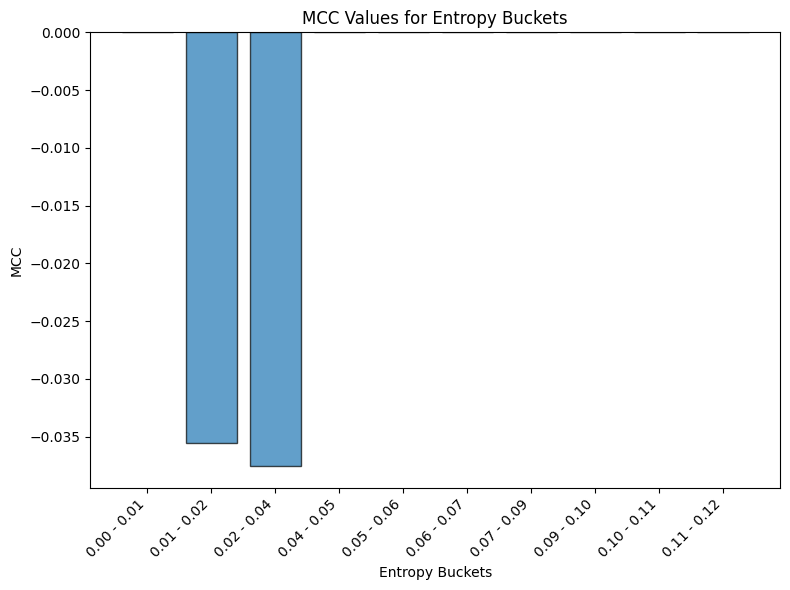

EPOCH END RESULTS MCC: -0.024964822861015312, LOW: 0.0, MED: 0.0, HIGH: -0.02693041239528255
Finished fold: 8
BEST {'mcc': 0.06106236077756591, 'low_mcc': 0.0, 'med_mcc': 0.0, 'high_mcc': 0.07896100525895697, 'set_name': 'SG_SET_nitrilase_binary.pkl', 'std_devs': array([0.01974101, 0.00527388, 0.02380102, 0.02133676, 0.01956563,
       0.03029428, 0.02178534, 0.01113112, 0.02252585, 0.02146502,
       0.02335249, 0.03068831, 0.03182121, 0.04623083, 0.04191528,
       0.01337998, 0.02137739, 0.01235739, 0.01421829, 0.00818565,
       0.01390733, 0.00461135, 0.0194149 , 0.00964125, 0.01369585,
       0.00917879, 0.013845  , 0.0160072 , 0.00887386, 0.02445927,
       0.0148093 , 0.02321305, 0.01652064, 0.01350021, 0.007568  ,
       0.01189902, 0.01385853, 0.00869713, 0.01313633, 0.00463605,
       0.01863722, 0.00770423, 0.01292044, 0.00921104, 0.01315774,
       0.01548272, 0.00811695, 0.02337634, 0.01384925, 0.02017406,
       0.01379521, 0.01318885, 0.00644616, 0.01113952, 0.01490734,

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.5456458926200867 mcc: -0.6979824404521128


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.36213046312332153 mcc: 0.004413807966238211


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.3283711075782776 mcc: 0.18897413911266783


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.22897860407829285 mcc: 0.18134312289852758


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.2538866400718689 mcc: 0.25265213463054104


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.30362653732299805 mcc: 0.24553692530735355


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.2689390778541565 mcc: 0.29766553159298514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.2898753583431244 mcc: 0.2784404013458798


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.21176600456237793 mcc: 0.291922716275595


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.2441694736480713 mcc: 0.37140218477234105


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.2553296387195587 mcc: 0.34539375908985265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.22582674026489258 mcc: 0.36384969722671945


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.20386482775211334 mcc: 0.3239601866109552


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.2075466513633728 mcc: 0.384146164543282


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.25332731008529663 mcc: 0.3790529525563857


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.3793163299560547 mcc: 0.44003453642577295


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.2313825786113739 mcc: 0.3853867158754341


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.195315420627594 mcc: 0.4080297725934361


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.21952395141124725 mcc: 0.3921581023095216


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.1844780147075653 mcc: 0.44320534622215885


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.11347338557243347 mcc: 0.4250406765049515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.13686978816986084 mcc: 0.48502258156218214


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.296529620885849 mcc: 0.3814357316032664


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.2467583864927292 mcc: 0.40489360243967515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.1722421944141388 mcc: 0.48455646732453606


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.21496185660362244 mcc: 0.4641207592608933


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.2599949538707733 mcc: 0.42724030989161244


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.18780621886253357 mcc: 0.42344455152074967


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.2615930438041687 mcc: 0.4425284973821051


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.296966016292572 mcc: 0.43304180392696484


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.12452662736177444 mcc: 0.4756546301095084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.3312970995903015 mcc: 0.3854793927763938


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.040162635921862797, pvalue=0.18237107249141987)


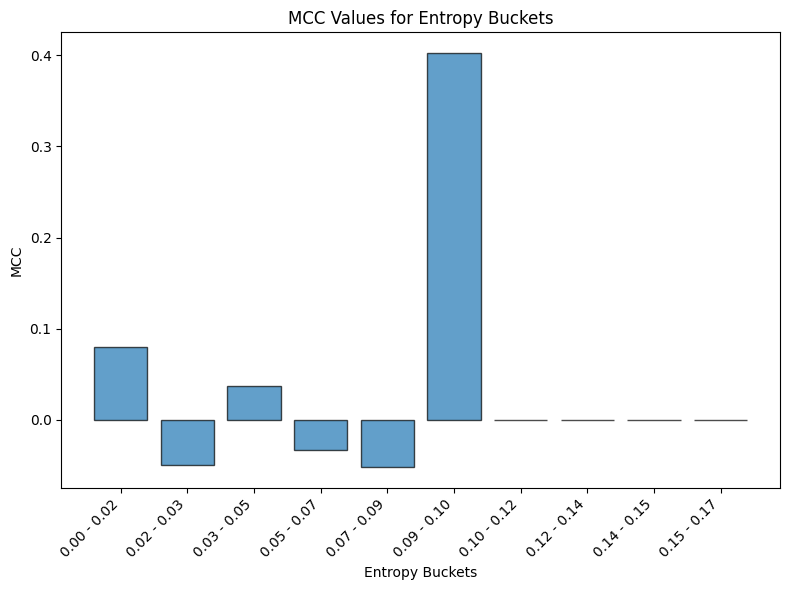

EPOCH END RESULTS MCC: 0.021917405827825445, LOW: 0.26696803146549475, MED: 0.024123952979370835, HIGH: -0.008181345412156699
--------------------
epoch: 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.26071083545684814 mcc: 0.3892494720807615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.17060573399066925 mcc: 0.49172689104554723


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.22871831059455872 mcc: 0.49561695822621105


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.33882033824920654 mcc: 0.44227789047921023


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.175150066614151 mcc: 0.46167248535391286


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.15229922533035278 mcc: 0.4250697703920619


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.14687220752239227 mcc: 0.47160941927397865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.2627927362918854 mcc: 0.48886585048764924


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.1437353491783142 mcc: 0.5087410970614077


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.20726311206817627 mcc: 0.5075380652717586


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.12481842190027237 mcc: 0.4351259951311927


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.22874414920806885 mcc: 0.4522577509446717


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.2619543969631195 mcc: 0.4852124151051894


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.18412816524505615 mcc: 0.4530268565576145


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.25441479682922363 mcc: 0.4475096501305651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.23836436867713928 mcc: 0.4720184229702058


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.24840950965881348 mcc: 0.4626093655751456


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.18985849618911743 mcc: 0.46811437791706056


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.22769923508167267 mcc: 0.49669768983243856


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.22346346080303192 mcc: 0.47729454733570265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.1366576850414276 mcc: 0.44899867503719304


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.3261854648590088 mcc: 0.47598976922725716


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.2802613079547882 mcc: 0.5083244895772109


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.12024618685245514 mcc: 0.4554451459075591


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.19010424613952637 mcc: 0.48703352382814125


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.19814042747020721 mcc: 0.47146992915933456


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.26360052824020386 mcc: 0.5011035294892165


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.18702039122581482 mcc: 0.4584800139173256


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.25251349806785583 mcc: 0.5138689594650616


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.18108372390270233 mcc: 0.44878357127277874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.18235766887664795 mcc: 0.44325421609146765


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.3065069317817688 mcc: 0.4989818805558146


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.07683952625730801, pvalue=0.010649551789387713)


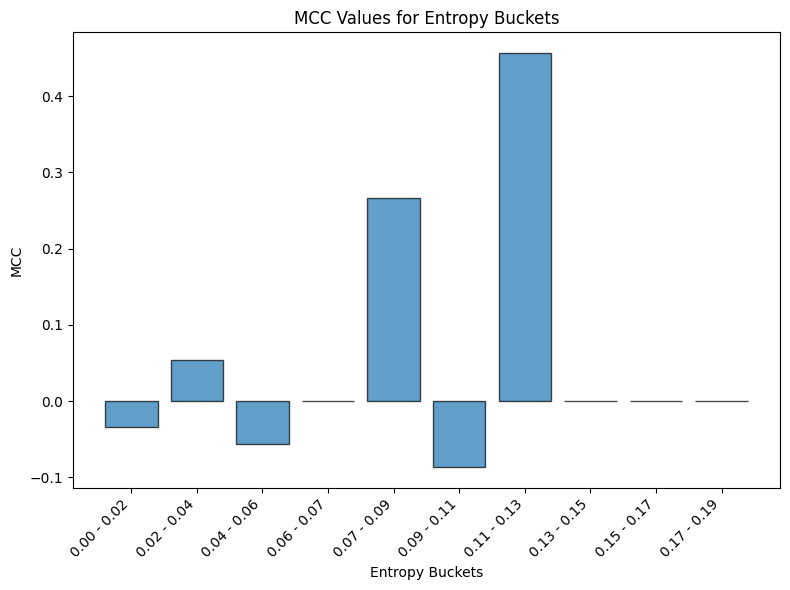

EPOCH END RESULTS MCC: 0.039211087385590926, LOW: 0.17262065139240032, MED: 0.01548248605293215, HIGH: 0.00357772148480978
--------------------
epoch: 2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.28467249870300293 mcc: 0.13250826977378266


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.12754936516284943 mcc: 0.48648562729097455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.13738104701042175 mcc: 0.4507984647745857


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.12386412918567657 mcc: 0.5332196178621952


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.20072869956493378 mcc: 0.4899213594129989


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.30678385496139526 mcc: 0.48707880529712344


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.17400315403938293 mcc: 0.46917881583060667


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.12190888822078705 mcc: 0.5151467104628171


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.2912714183330536 mcc: 0.5217619832007513


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.2938043773174286 mcc: 0.48816298796478774


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.3055085241794586 mcc: 0.49031556328045084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.17211557924747467 mcc: 0.4846485551518252


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.11476926505565643 mcc: 0.5132654497814164


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.11671590805053711 mcc: 0.5160914938763086


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.13660463690757751 mcc: 0.49580575644044517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.17556267976760864 mcc: 0.5006890845550178


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.2995559275150299 mcc: 0.46851669845788285


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.20297910273075104 mcc: 0.47287627635200136


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.18308676779270172 mcc: 0.512510721774014


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.15266700088977814 mcc: 0.4589609195496304


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.11777672916650772 mcc: 0.5272849256810533


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.22418853640556335 mcc: 0.4924145649969308


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.2170819789171219 mcc: 0.48922826527400265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.2575455904006958 mcc: 0.47213368726675636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.3234095871448517 mcc: 0.49645283694497216


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.23587539792060852 mcc: 0.4984776841339702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.11699265241622925 mcc: 0.48895555260524337


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.2202814817428589 mcc: 0.47548605167436236


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.1409498155117035 mcc: 0.4926945198928991


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.24339263141155243 mcc: 0.4753081327750976


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.15608258545398712 mcc: 0.49381551691580805


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.14303681254386902 mcc: 0.5116811790529123


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.14728917419686127, pvalue=8.869665516731374e-07)


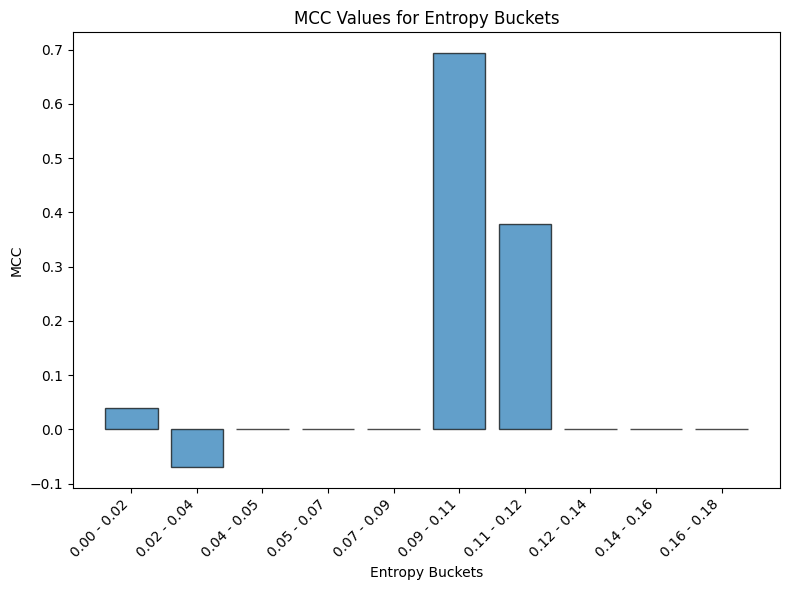

EPOCH END RESULTS MCC: 0.05477254574022738, LOW: 0.37997083023299505, MED: 0.0, HIGH: -0.004095508054838679
--------------------
epoch: 3


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.19171959161758423 mcc: 0.7141684885491869


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.2235303521156311 mcc: 0.486481673692586


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.16152101755142212 mcc: 0.5076561549084253


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.1683267205953598 mcc: 0.48864010185826495


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.12598994374275208 mcc: 0.5082673228335237


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.14406554400920868 mcc: 0.5069197505231114


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.1703214943408966 mcc: 0.5120557409041947


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.19124442338943481 mcc: 0.44081318134846514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.17028698325157166 mcc: 0.5103572530010531


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.12720292806625366 mcc: 0.5006104251470458


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.12092694640159607 mcc: 0.5556488240308205


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.14818747341632843 mcc: 0.5227239295968845


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.1551402509212494 mcc: 0.5001442911298711


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.21447300910949707 mcc: 0.5186562114405868


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.16433238983154297 mcc: 0.4833134807250643


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.2282799333333969 mcc: 0.5201854757614182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.1755359172821045 mcc: 0.5234348292099675


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.1020585298538208 mcc: 0.5439185780856538


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.19193477928638458 mcc: 0.5366008902765295


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.1456279158592224 mcc: 0.47974257731953845


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.09382989257574081 mcc: 0.5372636246963073


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.1294676959514618 mcc: 0.5140959978934729


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.2169453501701355 mcc: 0.5190825598547084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.13606339693069458 mcc: 0.5253919032406159


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.09630078822374344 mcc: 0.48378379618102824


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.2049393355846405 mcc: 0.5097284351017785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.16792723536491394 mcc: 0.4701755936638466


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.1949457824230194 mcc: 0.5178463646843483


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.1436251997947693 mcc: 0.5520510422813424


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.12014275044202805 mcc: 0.500179973272045


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.1548181176185608 mcc: 0.4699495697806895


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.2819404900074005 mcc: 0.4796019913694895


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=0.04589575988707059, pvalue=0.12750100520254445)


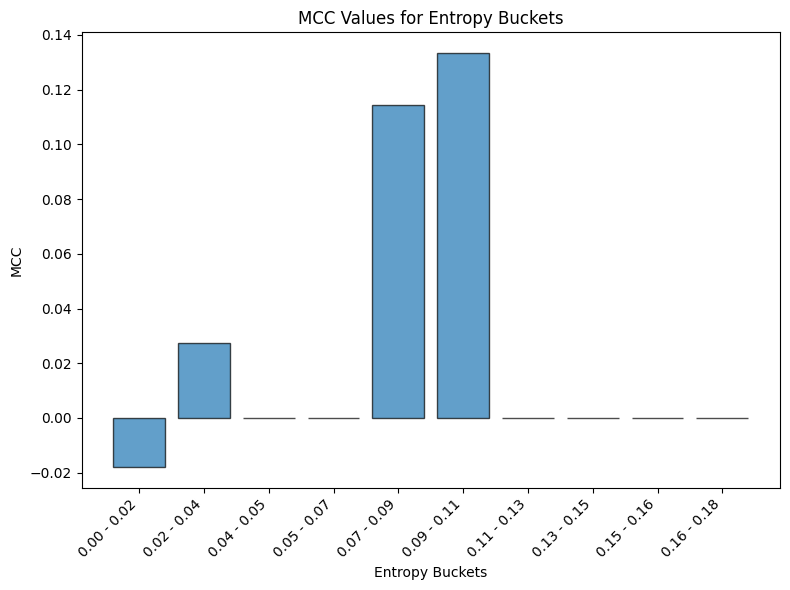

EPOCH END RESULTS MCC: 0.0336142676452744, LOW: 0.1741729706739032, MED: -0.019055142088725472, HIGH: 0.0017853150881841588
--------------------
epoch: 4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.27950650453567505 mcc: 0.47797332354820327


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.13566842675209045 mcc: 0.5274137944691807


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.15332724153995514 mcc: 0.5196117645408367


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.10601471364498138 mcc: 0.5113005778684572


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.1613456904888153 mcc: 0.545287562012511


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.13559433817863464 mcc: 0.5459270907923908


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.14232850074768066 mcc: 0.5337523048822598


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.18005311489105225 mcc: 0.5653978549442602


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.16807135939598083 mcc: 0.5095730080485341


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.13614730536937714 mcc: 0.4761168530481835


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.12054356187582016 mcc: 0.49862832569847126


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.13090994954109192 mcc: 0.5497178533331967


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.14876988530158997 mcc: 0.5410410406247304


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.15263617038726807 mcc: 0.5338944130288995


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.1770763397216797 mcc: 0.48152974978243307


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.12587234377861023 mcc: 0.49549112633662024


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.13337630033493042 mcc: 0.5020097205378481


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.23251605033874512 mcc: 0.5307988960371983


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.2173798531293869 mcc: 0.5124411436402144


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.31020572781562805 mcc: 0.5505159163896661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.1641922891139984 mcc: 0.5289357601433441


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.18867990374565125 mcc: 0.5268878745006265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.19070732593536377 mcc: 0.5211413689964784


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.23192958533763885 mcc: 0.5024054833046893


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.14786866307258606 mcc: 0.5407746318641691


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.1413896083831787 mcc: 0.5270534181764714


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.21535642445087433 mcc: 0.5098706123289859


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.3182249963283539 mcc: 0.4944541978610927


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.19643563032150269 mcc: 0.5289701966250546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.12231653928756714 mcc: 0.4954252286336951


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.1981746107339859 mcc: 0.4912870456177073


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.24041388928890228 mcc: 0.5395542895886211


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.16143744861613807, pvalue=6.91606551620385e-08)


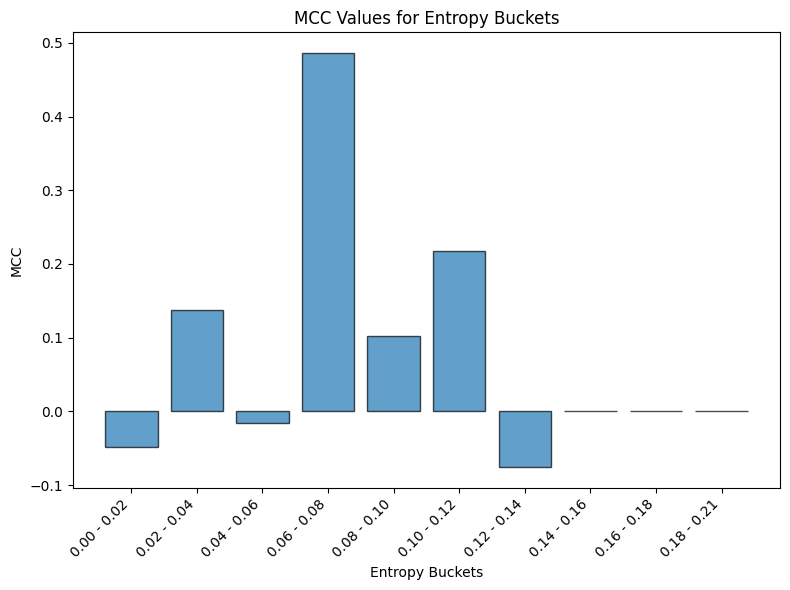

EPOCH END RESULTS MCC: 0.0371810680076572, LOW: 0.02874797872880345, MED: 0.2198584968911117, HIGH: 0.0
--------------------
epoch: 5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.1917460858821869 mcc: 0.4622501635210242


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.16736483573913574 mcc: 0.5155606944736156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.1801774501800537 mcc: 0.5619979162179386


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.10523313283920288 mcc: 0.5586041639259696


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.2212085723876953 mcc: 0.5234201298475396


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.24577297270298004 mcc: 0.5525476341697072


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.09379446506500244 mcc: 0.5625556382017477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.2505968511104584 mcc: 0.45989966306737085


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.12241314351558685 mcc: 0.5386467319747156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.17651823163032532 mcc: 0.5188708607038465


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.20967909693717957 mcc: 0.5169839540009615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.2545909881591797 mcc: 0.47212816126689205


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.13895386457443237 mcc: 0.5039676808079052


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.14342263340950012 mcc: 0.49256652791812167


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.18058036267757416 mcc: 0.5326460193930517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.16040383279323578 mcc: 0.5368064006915386


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.12351304292678833 mcc: 0.5186397295583858


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.1783897578716278 mcc: 0.5205844968455487


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.19219805300235748 mcc: 0.5867835123883381


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.20612633228302002 mcc: 0.514557134499587


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.14052365720272064 mcc: 0.5534053460070514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.26996952295303345 mcc: 0.5286027653999744


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.1787073016166687 mcc: 0.5428491118217044


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.12295052409172058 mcc: 0.4868212012149317


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.1668054163455963 mcc: 0.4998999785107432


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.11538463830947876 mcc: 0.5390558298311823


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.21226096153259277 mcc: 0.5492766869624592


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.16506323218345642 mcc: 0.5642114244114281


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.13400772213935852 mcc: 0.49334201090712526


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.129595547914505 mcc: 0.5037210419621518


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.16524142026901245 mcc: 0.529623909676751


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.19863125681877136 mcc: 0.5502250476316605


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.08494101481461677, pvalue=0.00473987491443674)


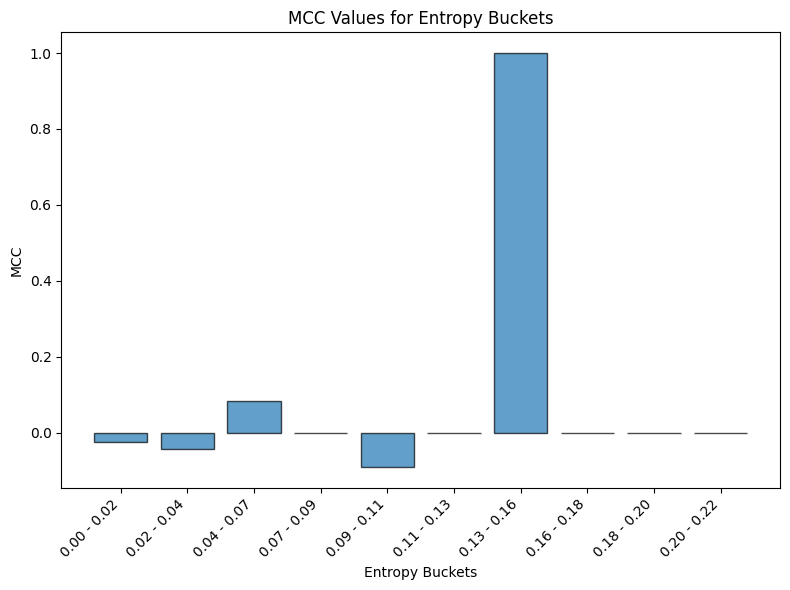

EPOCH END RESULTS MCC: 0.019348231278123604, LOW: 0.12110207841030628, MED: 0.06485904546590383, HIGH: -0.030448890313267963
--------------------
epoch: 6


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.1216086745262146 mcc: 0.7453559924999299


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.1116730198264122 mcc: 0.526423615736515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.1491173654794693 mcc: 0.5659810636270122


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.13953737914562225 mcc: 0.5005649911599703


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.14686375856399536 mcc: 0.5211351404751068


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.15052899718284607 mcc: 0.49918293564169275


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.12262074649333954 mcc: 0.5703927345049269


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.13690462708473206 mcc: 0.5864425019332544


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.1755526065826416 mcc: 0.5713210960258556


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.24497048556804657 mcc: 0.5302229116533488


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.10841121524572372 mcc: 0.5448972150595887


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.17003120481967926 mcc: 0.5275789431346951


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.2392675280570984 mcc: 0.5450402396476458


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.13470956683158875 mcc: 0.5142009202047761


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.14616098999977112 mcc: 0.5630313405921651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.19876889884471893 mcc: 0.5446686472249982


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.2843499183654785 mcc: 0.5345429967790616


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.29258406162261963 mcc: 0.5305424225330788


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.15588727593421936 mcc: 0.574271092881408


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.16301822662353516 mcc: 0.5533347689496054


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.21078373491764069 mcc: 0.5313215787489995


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.21233880519866943 mcc: 0.5321259587402088


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.10786651074886322 mcc: 0.5157831941654171


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.09414003044366837 mcc: 0.5507594616889916


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.14127163589000702 mcc: 0.5102982028877077


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.11700258404016495 mcc: 0.5344049011106333


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.1678973138332367 mcc: 0.5149201644653613


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.161797434091568 mcc: 0.5111023575918124


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.18059039115905762 mcc: 0.5492193099607999


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.12324360013008118 mcc: 0.5841483337775322


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.17966674268245697 mcc: 0.5247474410360677


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.17161065340042114 mcc: 0.5366980188080059


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.020495955874384332, pvalue=0.4963089702192522)


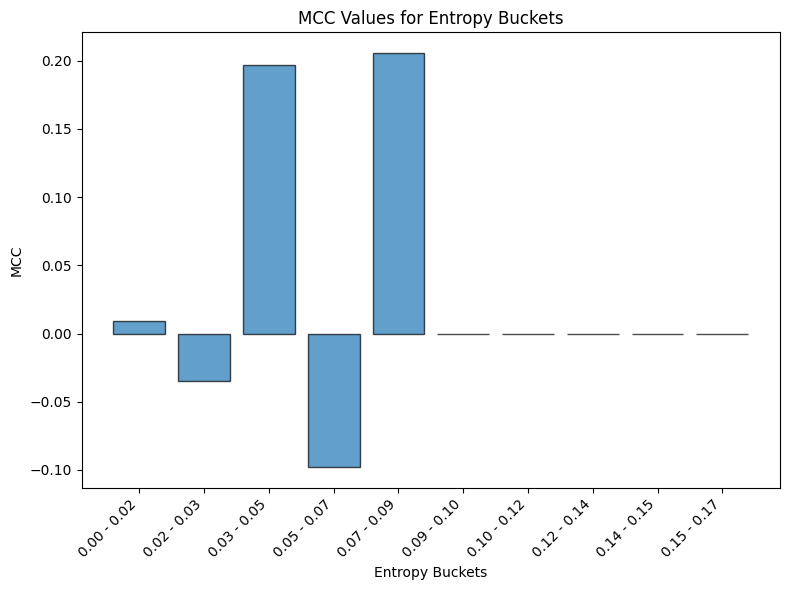

EPOCH END RESULTS MCC: 0.021595726744077726, LOW: 0.0, MED: 0.08025117801208306, HIGH: -0.00639452724769734
--------------------
epoch: 7


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.14464405179023743 mcc: 0.7624437362098716


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.2080528736114502 mcc: 0.5810112096996148


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.16002157330513 mcc: 0.5403366482558232


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.1456909477710724 mcc: 0.5652931662875658


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.11542172729969025 mcc: 0.571868478154835


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.17252959311008453 mcc: 0.5457229256843107


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.146306574344635 mcc: 0.5626718320747718


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.2416115552186966 mcc: 0.5354463218634464


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.19234241545200348 mcc: 0.46194185451308567


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.2411172240972519 mcc: 0.5576720953450365


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.14644402265548706 mcc: 0.4893010975912519


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.19367903470993042 mcc: 0.5559445922857762


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.1358404904603958 mcc: 0.5892699535744024


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.09319654107093811 mcc: 0.543650642144827


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.16939586400985718 mcc: 0.49634732123818803


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.13591402769088745 mcc: 0.5294500695737833


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.29173338413238525 mcc: 0.5463351988405616


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.20154118537902832 mcc: 0.5991334549141134


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.356440931558609 mcc: 0.5388829056084422


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.11505863070487976 mcc: 0.5591053785945385


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.16053469479084015 mcc: 0.552104668752797


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.16263878345489502 mcc: 0.5177434490217713


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.174431711435318 mcc: 0.52693647222314


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.11156844347715378 mcc: 0.5776648246121834


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.12146943807601929 mcc: 0.5416549647023888


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.15708044171333313 mcc: 0.5539882824788719


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.16140180826187134 mcc: 0.504696636249236


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.11612413078546524 mcc: 0.5107123569483998


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.1287858784198761 mcc: 0.5712912731536578


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.1613980531692505 mcc: 0.5615307039270699


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.2051679939031601 mcc: 0.5269371524163954


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.12806466221809387 mcc: 0.5778854858287832


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.14051702931885798, pvalue=2.7741318298049227e-06)


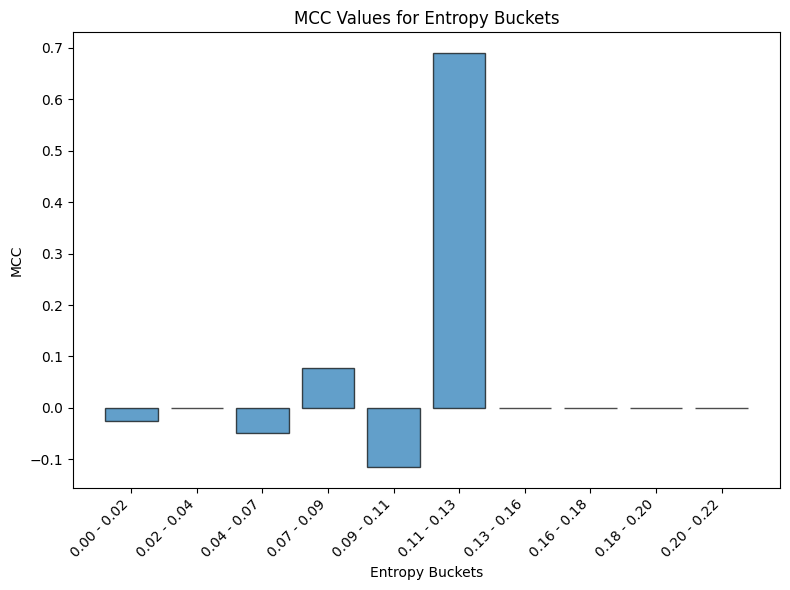

EPOCH END RESULTS MCC: 0.015089354927611725, LOW: 0.14327306166276627, MED: 0.021341937578647267, HIGH: -0.028514480230971175
--------------------
epoch: 8


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.08606303483247757 mcc: 0.687932430407656


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.12344440072774887 mcc: 0.590482098517058


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.16915546357631683 mcc: 0.5859105976831285


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.16375014185905457 mcc: 0.5702266541197012


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.14230936765670776 mcc: 0.5619089767393146


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.1429014801979065 mcc: 0.5583177987244725


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.12728475034236908 mcc: 0.5419198148255153


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.1716630458831787 mcc: 0.5480853417920315


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.18681403994560242 mcc: 0.5637579313096871


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.2401328682899475 mcc: 0.5502968614483108


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.21551814675331116 mcc: 0.5443709506284058


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.12702295184135437 mcc: 0.5338253584705451


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.14239433407783508 mcc: 0.5523136473430482


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.3169625401496887 mcc: 0.5207380470768139


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.13696303963661194 mcc: 0.5036567323076421


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.14033302664756775 mcc: 0.5325571634483296


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.12359398603439331 mcc: 0.5142192735675523


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.16384784877300262 mcc: 0.5700849885357583


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.12036631256341934 mcc: 0.5617825393620152


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.16574916243553162 mcc: 0.5916753414931404


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.14566726982593536 mcc: 0.5679806370777442


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.1599310338497162 mcc: 0.5368316910747658


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.1621169000864029 mcc: 0.5765029531910266


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.11767391115427017 mcc: 0.5570172992237054


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.11561016738414764 mcc: 0.5577329374800888


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.15921244025230408 mcc: 0.5305262684375631


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.11487364768981934 mcc: 0.5533817998144839


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.1640213429927826 mcc: 0.5575109630892231


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.10376328974962234 mcc: 0.5577977036346525


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.1988551914691925 mcc: 0.5911151161642759


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.13169313967227936 mcc: 0.5098715824136992


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.23659905791282654 mcc: 0.5900006016912308


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.07695096738645407, pvalue=0.01053646152350889)


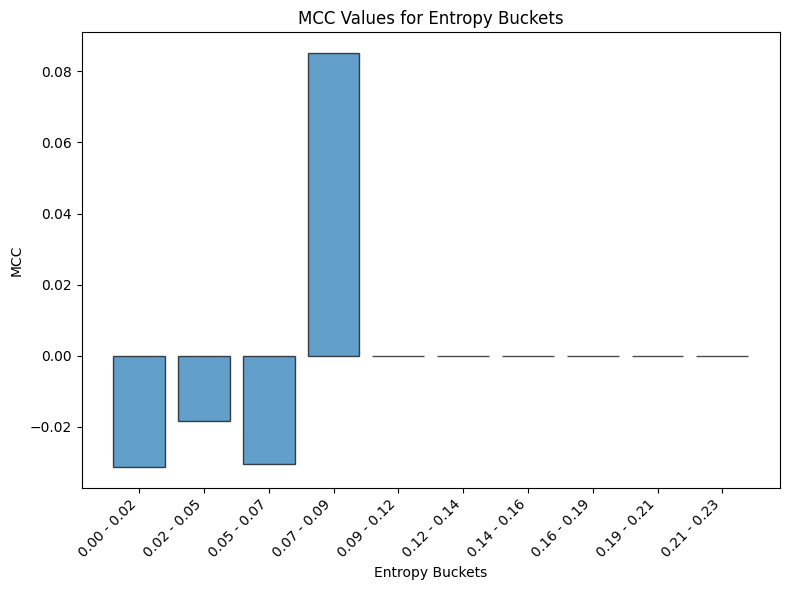

EPOCH END RESULTS MCC: -0.0014806888079498435, LOW: 0.13509250248777202, MED: -0.032805404676353817, HIGH: -0.029030596631501943
--------------------
epoch: 9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


STEP: 0/1574 loss: 0.11559263616800308 mcc: 0.5945883900105632


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 50/1574 loss: 0.197676420211792 mcc: 0.551937625211125


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 100/1574 loss: 0.13127994537353516 mcc: 0.5924612899715112


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 150/1574 loss: 0.11788475513458252 mcc: 0.5397186182537791


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 200/1574 loss: 0.24982859194278717 mcc: 0.5862761584018304


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 250/1574 loss: 0.12025906890630722 mcc: 0.5578562482465149


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 300/1574 loss: 0.1515682339668274 mcc: 0.5668084957034991


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 350/1574 loss: 0.09525664150714874 mcc: 0.5661107955792295


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 400/1574 loss: 0.13598385453224182 mcc: 0.5677088368955836


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 450/1574 loss: 0.10235262662172318 mcc: 0.5576638068977082


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 500/1574 loss: 0.11531644314527512 mcc: 0.5665235536939616


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 550/1574 loss: 0.11541660130023956 mcc: 0.5691985425934568


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 600/1574 loss: 0.16343532502651215 mcc: 0.5668667653255468


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 650/1574 loss: 0.10475198924541473 mcc: 0.5785364814796458


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 700/1574 loss: 0.1397256851196289 mcc: 0.5528478413596422


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 750/1574 loss: 0.16166795790195465 mcc: 0.6020554009898372


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 800/1574 loss: 0.1507280170917511 mcc: 0.5775624331787679


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 850/1574 loss: 0.20862816274166107 mcc: 0.572040126956671


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 900/1574 loss: 0.32004016637802124 mcc: 0.566776736102484


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 950/1574 loss: 0.1566898226737976 mcc: 0.591064954174941


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1000/1574 loss: 0.15309730172157288 mcc: 0.5513665226947027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1050/1574 loss: 0.20580682158470154 mcc: 0.56645324982607


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1100/1574 loss: 0.2623565196990967 mcc: 0.6086097245493771


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1150/1574 loss: 0.1415836066007614 mcc: 0.5660381608542548


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1200/1574 loss: 0.24493031203746796 mcc: 0.573549051833084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1250/1574 loss: 0.1840745359659195 mcc: 0.5693351820143885


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1300/1574 loss: 0.11950856447219849 mcc: 0.563254210465377


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1350/1574 loss: 0.1265157163143158 mcc: 0.5265709835618668


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1400/1574 loss: 0.1391482800245285 mcc: 0.5366662908140554


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1450/1574 loss: 0.1923852562904358 mcc: 0.569624792292036


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1500/1574 loss: 0.17121659219264984 mcc: 0.5429923479374092


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


STEP: 1550/1574 loss: 0.1828414797782898 mcc: 0.49287592006125375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CORRELATION PearsonRResult(statistic=-0.1536728251193344, pvalue=2.8862103493526714e-07)


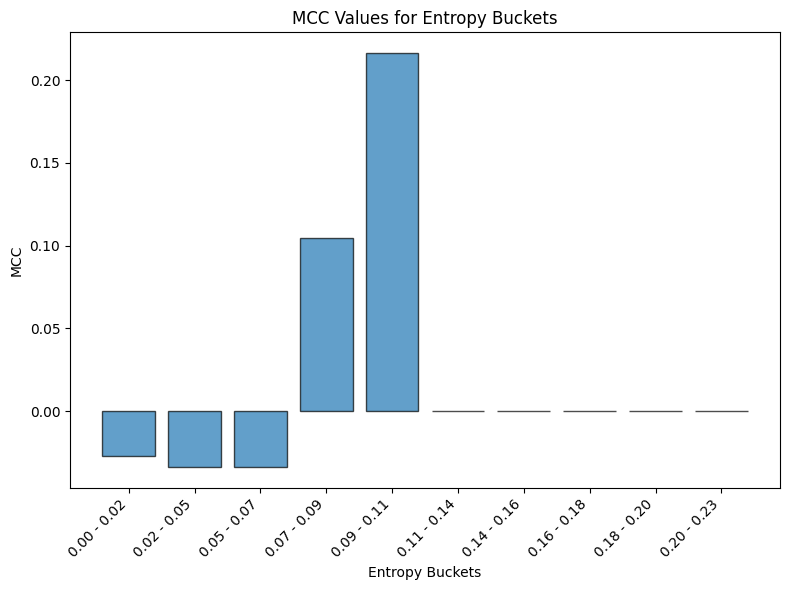

EPOCH END RESULTS MCC: 0.036565989872927175, LOW: 0.17438707171401888, MED: -0.053230429642548004, HIGH: -0.0258654523018417
Finished fold: 9
BEST {'mcc': 0.05477254574022738, 'low_mcc': 0.37997083023299505, 'med_mcc': 0.0, 'high_mcc': -0.004095508054838679, 'set_name': 'SG_SET_V5_XTB_STANDARDIZED_oxidoreductase_0.pkl', 'std_devs': array([0.07343285, 0.06949755, 0.01114515, ..., 0.15676856, 0.02063282,
       0.04163846], dtype=float32), 'per_epoch_mcc': [0.021917405827825445, 0.039211087385590926, 0.05477254574022738, 0.0336142676452744, 0.0371810680076572, 0.019348231278123604, 0.021595726744077726, 0.015089354927611725, -0.0014806888079498435, 0.036565989872927175], 'instability': 53.62955387597778}


In [ ]:
import os
import random
import torch
import statistics
import pickle

def calculate_cv(values):
    mean_value = np.mean(values)
    std_dev = np.std(values)
    cv = (std_dev / mean_value) * 100
    return cv

## Seeds generated with random.org with range 1 - 1000 from atmospheric noise
# set_seed(42)
# set_seed(836)
set_seed(77)

results = {}
y = None
tset = None

bt = None
bp = None

for x in range(len(sets)):
  print("--"*20)
  print("FOLD: ", x)
  print("--"*20)
  test_set = sets[x]
  train_set = pd.concat([sets[i] for i in range(len(sets)) if i != x])

  test_set = gen_uniprot_id(test_set)
  train_set = gen_uniprot_id(train_set)

  train_set = gen_mol_id(train_set)
  test_set = gen_mol_id(test_set)

  train_set = map_embds(train_set,True)
  test_set = map_embds(test_set,False)

  train_set['loss_weight'] = 1.0
  test_set['loss_weight'] = 1.0

  trainDataset = CustomDataset(train_set)
  testDataset = CustomDataset(test_set)

  trainLoader = DataLoader(trainDataset,batch_size=32,num_workers=4,shuffle=True,collate_fn=custom_collate,pin_memory=True,drop_last=True)
  testLoader = DataLoader(testDataset,batch_size=48,shuffle=False,num_workers=4,collate_fn=custom_collate,drop_last=True)


  ################################################
  ################################################

  models = []
  for i in range(3):
    model = DeepLPI(1024,768,dropout=0.2)
    optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=0.0002)
    models.append((model,optimizer))

  scheduler = None

  best_epoch_mcc = 0.0

  results[x] = {
          "acc": -9.9,
          "auroc": -9.9,
          "mcc": 0.0,
          "auprc": -9.9,
          "set_name": names[x],
          "per_epoch_mcc": [],
          "instability": -9.9,
          "std_devs": None
  }

  epoch_mcc = []

  for epoch in range(10):
      print("--"*10)
      print("epoch: " + str(epoch))

      avgloss = train_loop(models, trainLoader, None, scheduler,log=False)
      global_mcc, low_mcc, med_mcc, high_mcc, preds, truth, std_devs = test_loop(models, testLoader, 0,set,subset=False)


      print(f"EPOCH END RESULTS MCC: {global_mcc}, LOW: {low_mcc}, MED: {med_mcc}, HIGH: {high_mcc}")
      epoch_mcc.append(global_mcc)

      if global_mcc > best_epoch_mcc:
        best_epoch_mcc = global_mcc
        results[x] = {
          "mcc": global_mcc,
          "low_mcc": low_mcc,
          "med_mcc": med_mcc,
          "high_mcc": high_mcc,
          "set_name": names[x],
          "std_devs": std_devs
        }
  results[x]['per_epoch_mcc'] = epoch_mcc
  results[x]['instability'] = calculate_cv(epoch_mcc)

  import gc
  model.cpu()
  del model
  gc.collect()
  torch.cuda.empty_cache()

  print(f"Finished fold: {x}")
  print("BEST",results[x])